In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#from utils import mnist, plot_graphs, plot_mnist, to_onehot
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
# utils
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape, show=True, save_to=None):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    if save_to is not None:
        plt.savefig(save_to)
        
    if show:
        plt.show()
    else:
        plt.close()

    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()
        
        
def to_onehot(x, n, device=None):
    if isinstance(x, np.ndarray):
        x = torch.Tensor(x).to(torch.long)
    one_hot = torch.zeros((x.shape[0], n))
    one_hot.scatter_(1, x[:, None], 1.)
    if device is not None:
        one_hot = one_hot.to(device)
    return one_hot

In [4]:
root_folder = 'FC_AAE_CLSF_results'
fixed_folder = root_folder + '/Fixed_results/'
recon_folder = root_folder + '/Recon_results/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(recon_folder)

In [5]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 10
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((10, prior_size)).repeat((1,10)).view(-1, prior_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)

cpu


In [7]:
data, label = next(iter(train_loader))

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [9]:
Enc = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
Dec = FullyConnected([prior_size+10, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)
Disc = FullyConnected([prior_size, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

Enc_true = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
Dec_true = FullyConnected([prior_size+10, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)

Disc_true = FullyConnected([prior_size+10, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_true_optimizer = optim.Adam(Enc_true.parameters(), lr=lr)
Dec_true_optimizer = optim.Adam(Dec_true.parameters(), lr=lr)
Disc_true_optimizer = optim.Adam(Disc_true.parameters(), lr=lr)


In [10]:
Disc_true

FullyConnected(
  (model): Sequential(
    (0): Linear(in_features=20, out_features=1024, bias=True)
    (1): Dropout(p=0.3)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): Dropout(p=0.3)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [11]:
train_log = {'E': [],'AE': [], 'D': []}
test_log = {'E': [],'AE': [], 'D': []}

In [12]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [13]:
def train(epoch, Enc, Dec, Disc, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        label = to_onehot(label, 10, device)
        # train D
        Enc.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)

        fake_pred = Disc(Enc(data))
        true_pred = Disc(z)
        

        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_loss = 0.5*(fake_loss + true_loss)
        
        Disc_loss.backward()
        Disc_optimizer.step()
        
        # train AE
        Enc.zero_grad()
        Dec.zero_grad()
        Disc.zero_grad()
        
        
        latent = Enc(data)
        reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
        fake_pred = Disc(latent)
        
        Enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_loss
        
        G_loss.backward()
        Dec_optimizer.step()
        Enc_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
        print(line + losses)
        log['E'].append(Enc_loss.item())
        log['AE'].append(AE_loss.item())
        log['D'].append(Disc_loss.item())

In [14]:
def train_true(epoch, Enc_true, Dec_true, Disc_true, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        label = to_onehot(label, 10, device)
        # train D
        Enc_true.zero_grad()
        Disc_true.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)


        fake_pred = Disc_true(Enc_true(data), label)
        true_pred = Disc_true(z, z_label)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_true_loss = 0.5*(fake_loss + true_loss)
        
        Disc_true_loss.backward()
        Disc_true_optimizer.step()
        
        # train AE
        Enc_true.zero_grad()
        Dec_true.zero_grad()
        Disc_true.zero_grad()

        
        latent = Enc_true(data)
        reconstructed = Dec_true(latent, label).view(-1, 1, 28, 28)
        fake_pred = Disc_true(latent, label)
        
        Enc_true_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_true_loss
        
        G_loss.backward()
        Dec_true_optimizer.step()
        Enc_true_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_true_loss.item(), AE_loss.item(), Disc_true_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_true_loss.item(), AE_loss.item(), Disc_true_loss.item())
        print(line + losses)
        log['E'].append(Enc_true_loss.item())
        log['AE'].append(AE_loss.item())
        log['D'].append(Disc_true_loss.item())

In [17]:
def test(Enc, Dec, Disc, loader, epoch, log=None):
    test_size = len(loader)
    E_loss = 0.
    AE_loss = 0.
    D_loss = 0.
    test_loss = {'E': 0., 'AE': 0., 'D': 0.}
    with torch.no_grad():
        for data, label in loader:
            label = to_onehot(label, 10, device)
            z = torch.randn((batch_size, prior_size)).to(device)
            z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)
            latent = Enc(data)
            reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
            fake_pred = Disc(latent)
            true_pred = Disc(z)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            E_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            AE_loss += F.mse_loss(reconstructed, data)
            
        E_loss /= test_size
        D_loss /= test_size
        AE_loss /= test_size

        #fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        #plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
        #fixed_reconstruction = Dec(Enc(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        #plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(E_loss, AE_loss, D_loss)
    print(report)

In [18]:
def test_true(Enc_true, Dec_true, Disc_true, loader, epoch, log=None):
    test_size = len(loader)
    E_true_loss = 0.
    AE_loss = 0.
    D_true_loss = 0.
    test_loss = {'E': 0., 'AE': 0., 'D': 0.}
    with torch.no_grad():
        for data, label in loader:
            label = to_onehot(label, 10, device)
            z = torch.randn((batch_size, prior_size)).to(device)
            z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)
            latent = Enc_true(data)
            reconstructed = Dec_true(latent, label).view(-1, 1, 28, 28)
            fake_pred = Disc_true(latent, label)
            true_pred = Disc_true(z, z_label)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_true_loss += 0.5*(fake_loss + true_loss)
            E_true_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            AE_loss += F.mse_loss(reconstructed, data)
            
        E_true_loss /= test_size
        D_true_loss /= test_size
        AE_loss /= test_size

        #fixed_gen = Dec_true(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        #plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
        #fixed_reconstruction = Dec_true(Enc_true(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        #plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(E_true_loss, AE_loss, D_true_loss)
    print(report)

In [19]:
for epoch in range(1, 1001):
    #aae_c
    Enc.train()
    Dec.train()
    Disc.train()
    train(epoch, Enc, Dec, Disc, train_log)
    Enc.eval()
    Dec.eval()
    Disc.eval()
    test(Enc, Dec, Disc, valid_loader, epoch, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses E: 0.6672, AE: 0.9288, D: 0.6860
Train Epoch: 1 [25000/50000 (50%)]	Losses E: 8.8899, AE: 0.2789, D: 2.7479
Train Epoch: 1 [50000/50000 (100%)]	Losses E: 0.8619, AE: 0.2712, D: 1.7741
Test losses. E: 0.8546, AE: 0.2727, D: 1.6884
Train Epoch: 2 [0/50000 (0%)]	Losses E: 0.8611, AE: 0.2735, D: 1.6920
Train Epoch: 2 [25000/50000 (50%)]	Losses E: 0.6151, AE: 0.2515, D: 1.0171
Train Epoch: 2 [50000/50000 (100%)]	Losses E: 0.7594, AE: 0.2476, D: 0.9509
Test losses. E: 0.4378, AE: 0.2498, D: 1.0113
Train Epoch: 3 [0/50000 (0%)]	Losses E: 0.7711, AE: 0.2489, D: 0.9466
Train Epoch: 3 [25000/50000 (50%)]	Losses E: 0.6278, AE: 0.2457, D: 0.9525
Train Epoch: 3 [50000/50000 (100%)]	Losses E: 0.5340, AE: 0.2315, D: 0.7906
Test losses. E: 0.5059, AE: 0.2317, D: 0.7876
Train Epoch: 4 [0/50000 (0%)]	Losses E: 0.5275, AE: 0.2349, D: 0.7838
Train Epoch: 4 [25000/50000 (50%)]	Losses E: 0.6512, AE: 0.2216, D: 0.8383
Train Epoch: 4 [50000/50000 (100%)]	Losses E: 0.5745, 

Train Epoch: 31 [50000/50000 (100%)]	Losses E: 0.6398, AE: 0.1260, D: 0.7001
Test losses. E: 0.6352, AE: 0.1241, D: 0.7025
Train Epoch: 32 [0/50000 (0%)]	Losses E: 0.6357, AE: 0.1262, D: 0.7016
Train Epoch: 32 [25000/50000 (50%)]	Losses E: 0.7618, AE: 0.1224, D: 0.6879
Train Epoch: 32 [50000/50000 (100%)]	Losses E: 0.6896, AE: 0.1193, D: 0.7174
Test losses. E: 0.6872, AE: 0.1197, D: 0.7142
Train Epoch: 33 [0/50000 (0%)]	Losses E: 0.6905, AE: 0.1179, D: 0.7166
Train Epoch: 33 [25000/50000 (50%)]	Losses E: 0.6868, AE: 0.1380, D: 0.7022
Train Epoch: 33 [50000/50000 (100%)]	Losses E: 0.6737, AE: 0.1151, D: 0.6862
Test losses. E: 0.6737, AE: 0.1182, D: 0.6832
Train Epoch: 34 [0/50000 (0%)]	Losses E: 0.6714, AE: 0.1215, D: 0.6842
Train Epoch: 34 [25000/50000 (50%)]	Losses E: 0.7456, AE: 0.1351, D: 0.7375
Train Epoch: 34 [50000/50000 (100%)]	Losses E: 0.6749, AE: 0.1139, D: 0.7024
Test losses. E: 0.6686, AE: 0.1176, D: 0.7036
Train Epoch: 35 [0/50000 (0%)]	Losses E: 0.6677, AE: 0.1204, D: 0.7

Train Epoch: 62 [0/50000 (0%)]	Losses E: 0.6337, AE: 0.0879, D: 0.6940
Train Epoch: 62 [25000/50000 (50%)]	Losses E: 0.6531, AE: 0.0857, D: 0.7100
Train Epoch: 62 [50000/50000 (100%)]	Losses E: 0.6611, AE: 0.1107, D: 0.7147
Test losses. E: 0.6513, AE: 0.1085, D: 0.7134
Train Epoch: 63 [0/50000 (0%)]	Losses E: 0.6512, AE: 0.1092, D: 0.7132
Train Epoch: 63 [25000/50000 (50%)]	Losses E: 0.6771, AE: 0.1026, D: 0.7025
Train Epoch: 63 [50000/50000 (100%)]	Losses E: 0.6843, AE: 0.0904, D: 0.6910
Test losses. E: 0.6804, AE: 0.0904, D: 0.6914
Train Epoch: 64 [0/50000 (0%)]	Losses E: 0.6789, AE: 0.0922, D: 0.6921
Train Epoch: 64 [25000/50000 (50%)]	Losses E: 0.7477, AE: 0.0923, D: 0.7000
Train Epoch: 64 [50000/50000 (100%)]	Losses E: 0.6919, AE: 0.0940, D: 0.7034
Test losses. E: 0.6897, AE: 0.0874, D: 0.7029
Train Epoch: 65 [0/50000 (0%)]	Losses E: 0.6927, AE: 0.0865, D: 0.7034
Train Epoch: 65 [25000/50000 (50%)]	Losses E: 0.7352, AE: 0.0985, D: 0.7016
Train Epoch: 65 [50000/50000 (100%)]	Losses

Train Epoch: 92 [50000/50000 (100%)]	Losses E: 0.7265, AE: 0.0770, D: 0.6904
Test losses. E: 0.7231, AE: 0.0781, D: 0.6908
Train Epoch: 93 [0/50000 (0%)]	Losses E: 0.7290, AE: 0.0772, D: 0.6920
Train Epoch: 93 [25000/50000 (50%)]	Losses E: 0.6721, AE: 0.0738, D: 0.6984
Train Epoch: 93 [50000/50000 (100%)]	Losses E: 0.7052, AE: 0.0719, D: 0.6824
Test losses. E: 0.6990, AE: 0.0757, D: 0.6820
Train Epoch: 94 [0/50000 (0%)]	Losses E: 0.7040, AE: 0.0762, D: 0.6836
Train Epoch: 94 [25000/50000 (50%)]	Losses E: 0.6923, AE: 0.0801, D: 0.7094
Train Epoch: 94 [50000/50000 (100%)]	Losses E: 0.7482, AE: 0.0717, D: 0.6991
Test losses. E: 0.7473, AE: 0.0742, D: 0.6996
Train Epoch: 95 [0/50000 (0%)]	Losses E: 0.7435, AE: 0.0723, D: 0.6980
Train Epoch: 95 [25000/50000 (50%)]	Losses E: 0.7553, AE: 0.0829, D: 0.7018
Train Epoch: 95 [50000/50000 (100%)]	Losses E: 0.7253, AE: 0.0821, D: 0.7044
Test losses. E: 0.7245, AE: 0.0813, D: 0.7022
Train Epoch: 96 [0/50000 (0%)]	Losses E: 0.7253, AE: 0.0826, D: 0.7

Test losses. E: 0.6885, AE: 0.0748, D: 0.6913
Train Epoch: 123 [0/50000 (0%)]	Losses E: 0.6944, AE: 0.0756, D: 0.6913
Train Epoch: 123 [25000/50000 (50%)]	Losses E: 0.6593, AE: 0.0673, D: 0.6974
Train Epoch: 123 [50000/50000 (100%)]	Losses E: 0.6861, AE: 0.0782, D: 0.7044
Test losses. E: 0.6847, AE: 0.0767, D: 0.7020
Train Epoch: 124 [0/50000 (0%)]	Losses E: 0.6888, AE: 0.0780, D: 0.7037
Train Epoch: 124 [25000/50000 (50%)]	Losses E: 0.6750, AE: 0.0636, D: 0.6907
Train Epoch: 124 [50000/50000 (100%)]	Losses E: 0.7017, AE: 0.0637, D: 0.6962
Test losses. E: 0.7011, AE: 0.0661, D: 0.6945
Train Epoch: 125 [0/50000 (0%)]	Losses E: 0.6998, AE: 0.0652, D: 0.6952
Train Epoch: 125 [25000/50000 (50%)]	Losses E: 0.6916, AE: 0.0616, D: 0.6892
Train Epoch: 125 [50000/50000 (100%)]	Losses E: 0.6848, AE: 0.0653, D: 0.6952
Test losses. E: 0.6852, AE: 0.0654, D: 0.6948
Train Epoch: 126 [0/50000 (0%)]	Losses E: 0.6850, AE: 0.0621, D: 0.6945
Train Epoch: 126 [25000/50000 (50%)]	Losses E: 0.6938, AE: 0.07

Train Epoch: 153 [0/50000 (0%)]	Losses E: 0.6875, AE: 0.0546, D: 0.6935
Train Epoch: 153 [25000/50000 (50%)]	Losses E: 0.6807, AE: 0.0536, D: 0.6926
Train Epoch: 153 [50000/50000 (100%)]	Losses E: 0.6836, AE: 0.0515, D: 0.6940
Test losses. E: 0.6834, AE: 0.0551, D: 0.6944
Train Epoch: 154 [0/50000 (0%)]	Losses E: 0.6837, AE: 0.0543, D: 0.6946
Train Epoch: 154 [25000/50000 (50%)]	Losses E: 0.6828, AE: 0.0565, D: 0.6946
Train Epoch: 154 [50000/50000 (100%)]	Losses E: 0.6847, AE: 0.0526, D: 0.6950
Test losses. E: 0.6849, AE: 0.0551, D: 0.6945
Train Epoch: 155 [0/50000 (0%)]	Losses E: 0.6862, AE: 0.0512, D: 0.6951
Train Epoch: 155 [25000/50000 (50%)]	Losses E: 0.7023, AE: 0.0507, D: 0.6956
Train Epoch: 155 [50000/50000 (100%)]	Losses E: 0.7074, AE: 0.0556, D: 0.6939
Test losses. E: 0.7076, AE: 0.0546, D: 0.6933
Train Epoch: 156 [0/50000 (0%)]	Losses E: 0.7078, AE: 0.0524, D: 0.6936
Train Epoch: 156 [25000/50000 (50%)]	Losses E: 0.7079, AE: 0.0533, D: 0.6923
Train Epoch: 156 [50000/50000 (1

Train Epoch: 183 [25000/50000 (50%)]	Losses E: 0.6922, AE: 0.0434, D: 0.6946
Train Epoch: 183 [50000/50000 (100%)]	Losses E: 0.6936, AE: 0.0434, D: 0.6947
Test losses. E: 0.6936, AE: 0.0471, D: 0.6941
Train Epoch: 184 [0/50000 (0%)]	Losses E: 0.6939, AE: 0.0422, D: 0.6952
Train Epoch: 184 [25000/50000 (50%)]	Losses E: 0.6949, AE: 0.0455, D: 0.6942
Train Epoch: 184 [50000/50000 (100%)]	Losses E: 0.6962, AE: 0.0446, D: 0.6924
Test losses. E: 0.6949, AE: 0.0469, D: 0.6924
Train Epoch: 185 [0/50000 (0%)]	Losses E: 0.6941, AE: 0.0413, D: 0.6932
Train Epoch: 185 [25000/50000 (50%)]	Losses E: 0.6749, AE: 0.0466, D: 0.6941
Train Epoch: 185 [50000/50000 (100%)]	Losses E: 0.6919, AE: 0.0425, D: 0.6934
Test losses. E: 0.6926, AE: 0.0468, D: 0.6937
Train Epoch: 186 [0/50000 (0%)]	Losses E: 0.6918, AE: 0.0433, D: 0.6938
Train Epoch: 186 [25000/50000 (50%)]	Losses E: 0.6848, AE: 0.0423, D: 0.6932
Train Epoch: 186 [50000/50000 (100%)]	Losses E: 0.6972, AE: 0.0420, D: 0.6928
Test losses. E: 0.6969, AE

Train Epoch: 213 [50000/50000 (100%)]	Losses E: 0.6872, AE: 0.0405, D: 0.6927
Test losses. E: 0.6864, AE: 0.0442, D: 0.6928
Train Epoch: 214 [0/50000 (0%)]	Losses E: 0.6859, AE: 0.0381, D: 0.6931
Train Epoch: 214 [25000/50000 (50%)]	Losses E: 0.6961, AE: 0.0361, D: 0.6931
Train Epoch: 214 [50000/50000 (100%)]	Losses E: 0.6918, AE: 0.0408, D: 0.6934
Test losses. E: 0.6919, AE: 0.0442, D: 0.6933
Train Epoch: 215 [0/50000 (0%)]	Losses E: 0.6922, AE: 0.0364, D: 0.6936
Train Epoch: 215 [25000/50000 (50%)]	Losses E: 0.6986, AE: 0.0385, D: 0.6936
Train Epoch: 215 [50000/50000 (100%)]	Losses E: 0.6917, AE: 0.0408, D: 0.6941
Test losses. E: 0.6925, AE: 0.0437, D: 0.6934
Train Epoch: 216 [0/50000 (0%)]	Losses E: 0.6935, AE: 0.0355, D: 0.6941
Train Epoch: 216 [25000/50000 (50%)]	Losses E: 0.6963, AE: 0.0367, D: 0.6926
Train Epoch: 216 [50000/50000 (100%)]	Losses E: 0.6940, AE: 0.0366, D: 0.6934
Test losses. E: 0.6951, AE: 0.0433, D: 0.6931
Train Epoch: 217 [0/50000 (0%)]	Losses E: 0.6957, AE: 0.0

Test losses. E: 0.6980, AE: 0.0423, D: 0.6932
Train Epoch: 244 [0/50000 (0%)]	Losses E: 0.6982, AE: 0.0347, D: 0.6933
Train Epoch: 244 [25000/50000 (50%)]	Losses E: 0.6923, AE: 0.0329, D: 0.6929
Train Epoch: 244 [50000/50000 (100%)]	Losses E: 0.6956, AE: 0.0356, D: 0.6934
Test losses. E: 0.6947, AE: 0.0426, D: 0.6933
Train Epoch: 245 [0/50000 (0%)]	Losses E: 0.6947, AE: 0.0334, D: 0.6935
Train Epoch: 245 [25000/50000 (50%)]	Losses E: 0.6917, AE: 0.0357, D: 0.6937
Train Epoch: 245 [50000/50000 (100%)]	Losses E: 0.6869, AE: 0.0343, D: 0.6943
Test losses. E: 0.6866, AE: 0.0427, D: 0.6936
Train Epoch: 246 [0/50000 (0%)]	Losses E: 0.6879, AE: 0.0343, D: 0.6933
Train Epoch: 246 [25000/50000 (50%)]	Losses E: 0.6943, AE: 0.0359, D: 0.6931
Train Epoch: 246 [50000/50000 (100%)]	Losses E: 0.6898, AE: 0.0360, D: 0.6931
Test losses. E: 0.6886, AE: 0.0424, D: 0.6929
Train Epoch: 247 [0/50000 (0%)]	Losses E: 0.6907, AE: 0.0360, D: 0.6926
Train Epoch: 247 [25000/50000 (50%)]	Losses E: 0.6888, AE: 0.03

Train Epoch: 274 [0/50000 (0%)]	Losses E: 0.6931, AE: 0.0345, D: 0.6928
Train Epoch: 274 [25000/50000 (50%)]	Losses E: 0.6970, AE: 0.0321, D: 0.6918
Train Epoch: 274 [50000/50000 (100%)]	Losses E: 0.6988, AE: 0.0348, D: 0.6931
Test losses. E: 0.6963, AE: 0.0421, D: 0.6929
Train Epoch: 275 [0/50000 (0%)]	Losses E: 0.6978, AE: 0.0323, D: 0.6931
Train Epoch: 275 [25000/50000 (50%)]	Losses E: 0.6990, AE: 0.0319, D: 0.6918
Train Epoch: 275 [50000/50000 (100%)]	Losses E: 0.6915, AE: 0.0335, D: 0.6929
Test losses. E: 0.6918, AE: 0.0418, D: 0.6930
Train Epoch: 276 [0/50000 (0%)]	Losses E: 0.6929, AE: 0.0364, D: 0.6937
Train Epoch: 276 [25000/50000 (50%)]	Losses E: 0.6937, AE: 0.0352, D: 0.6936
Train Epoch: 276 [50000/50000 (100%)]	Losses E: 0.6961, AE: 0.0340, D: 0.6934
Test losses. E: 0.6963, AE: 0.0420, D: 0.6935
Train Epoch: 277 [0/50000 (0%)]	Losses E: 0.6993, AE: 0.0315, D: 0.6935
Train Epoch: 277 [25000/50000 (50%)]	Losses E: 0.6965, AE: 0.0357, D: 0.6936
Train Epoch: 277 [50000/50000 (1

Train Epoch: 304 [25000/50000 (50%)]	Losses E: 0.6908, AE: 0.0313, D: 0.6941
Train Epoch: 304 [50000/50000 (100%)]	Losses E: 0.6952, AE: 0.0328, D: 0.6933
Test losses. E: 0.6939, AE: 0.0418, D: 0.6934
Train Epoch: 305 [0/50000 (0%)]	Losses E: 0.6942, AE: 0.0328, D: 0.6941
Train Epoch: 305 [25000/50000 (50%)]	Losses E: 0.6909, AE: 0.0338, D: 0.6936
Train Epoch: 305 [50000/50000 (100%)]	Losses E: 0.6912, AE: 0.0298, D: 0.6928
Test losses. E: 0.6911, AE: 0.0415, D: 0.6931
Train Epoch: 306 [0/50000 (0%)]	Losses E: 0.6912, AE: 0.0321, D: 0.6927
Train Epoch: 306 [25000/50000 (50%)]	Losses E: 0.6926, AE: 0.0320, D: 0.6933
Train Epoch: 306 [50000/50000 (100%)]	Losses E: 0.6904, AE: 0.0329, D: 0.6931
Test losses. E: 0.6902, AE: 0.0417, D: 0.6931
Train Epoch: 307 [0/50000 (0%)]	Losses E: 0.6909, AE: 0.0295, D: 0.6931
Train Epoch: 307 [25000/50000 (50%)]	Losses E: 0.6947, AE: 0.0310, D: 0.6932
Train Epoch: 307 [50000/50000 (100%)]	Losses E: 0.6938, AE: 0.0322, D: 0.6936
Test losses. E: 0.6935, AE

Train Epoch: 334 [50000/50000 (100%)]	Losses E: 0.6967, AE: 0.0305, D: 0.6928
Test losses. E: 0.6961, AE: 0.0414, D: 0.6930
Train Epoch: 335 [0/50000 (0%)]	Losses E: 0.6961, AE: 0.0309, D: 0.6938
Train Epoch: 335 [25000/50000 (50%)]	Losses E: 0.6970, AE: 0.0289, D: 0.6924
Train Epoch: 335 [50000/50000 (100%)]	Losses E: 0.6974, AE: 0.0314, D: 0.6933
Test losses. E: 0.6956, AE: 0.0415, D: 0.6932
Train Epoch: 336 [0/50000 (0%)]	Losses E: 0.6980, AE: 0.0285, D: 0.6928
Train Epoch: 336 [25000/50000 (50%)]	Losses E: 0.6857, AE: 0.0301, D: 0.6927
Train Epoch: 336 [50000/50000 (100%)]	Losses E: 0.6932, AE: 0.0298, D: 0.6926
Test losses. E: 0.6916, AE: 0.0415, D: 0.6931
Train Epoch: 337 [0/50000 (0%)]	Losses E: 0.6910, AE: 0.0310, D: 0.6932
Train Epoch: 337 [25000/50000 (50%)]	Losses E: 0.6877, AE: 0.0291, D: 0.6939
Train Epoch: 337 [50000/50000 (100%)]	Losses E: 0.6942, AE: 0.0314, D: 0.6931
Test losses. E: 0.6936, AE: 0.0416, D: 0.6933
Train Epoch: 338 [0/50000 (0%)]	Losses E: 0.6941, AE: 0.0

Test losses. E: 0.6979, AE: 0.0416, D: 0.6930
Train Epoch: 365 [0/50000 (0%)]	Losses E: 0.6986, AE: 0.0290, D: 0.6938
Train Epoch: 365 [25000/50000 (50%)]	Losses E: 0.6936, AE: 0.0295, D: 0.6932
Train Epoch: 365 [50000/50000 (100%)]	Losses E: 0.6977, AE: 0.0298, D: 0.6931
Test losses. E: 0.6977, AE: 0.0418, D: 0.6935
Train Epoch: 366 [0/50000 (0%)]	Losses E: 0.6995, AE: 0.0264, D: 0.6933
Train Epoch: 366 [25000/50000 (50%)]	Losses E: 0.6979, AE: 0.0278, D: 0.6923
Train Epoch: 366 [50000/50000 (100%)]	Losses E: 0.6881, AE: 0.0291, D: 0.6926
Test losses. E: 0.6869, AE: 0.0415, D: 0.6930
Train Epoch: 367 [0/50000 (0%)]	Losses E: 0.6879, AE: 0.0296, D: 0.6933
Train Epoch: 367 [25000/50000 (50%)]	Losses E: 0.6925, AE: 0.0271, D: 0.6931
Train Epoch: 367 [50000/50000 (100%)]	Losses E: 0.6935, AE: 0.0288, D: 0.6930
Test losses. E: 0.6936, AE: 0.0417, D: 0.6932
Train Epoch: 368 [0/50000 (0%)]	Losses E: 0.6953, AE: 0.0282, D: 0.6935
Train Epoch: 368 [25000/50000 (50%)]	Losses E: 0.6892, AE: 0.02

Train Epoch: 395 [0/50000 (0%)]	Losses E: 0.6936, AE: 0.0287, D: 0.6934
Train Epoch: 395 [25000/50000 (50%)]	Losses E: 0.6932, AE: 0.0306, D: 0.6926
Train Epoch: 395 [50000/50000 (100%)]	Losses E: 0.6943, AE: 0.0274, D: 0.6923
Test losses. E: 0.6930, AE: 0.0418, D: 0.6931
Train Epoch: 396 [0/50000 (0%)]	Losses E: 0.6938, AE: 0.0291, D: 0.6932
Train Epoch: 396 [25000/50000 (50%)]	Losses E: 0.6962, AE: 0.0278, D: 0.6930
Train Epoch: 396 [50000/50000 (100%)]	Losses E: 0.6949, AE: 0.0272, D: 0.6937
Test losses. E: 0.6946, AE: 0.0422, D: 0.6935
Train Epoch: 397 [0/50000 (0%)]	Losses E: 0.6954, AE: 0.0276, D: 0.6940
Train Epoch: 397 [25000/50000 (50%)]	Losses E: 0.6913, AE: 0.0307, D: 0.6939
Train Epoch: 397 [50000/50000 (100%)]	Losses E: 0.6901, AE: 0.0288, D: 0.6931
Test losses. E: 0.6893, AE: 0.0420, D: 0.6935
Train Epoch: 398 [0/50000 (0%)]	Losses E: 0.6908, AE: 0.0270, D: 0.6925
Train Epoch: 398 [25000/50000 (50%)]	Losses E: 0.6960, AE: 0.0296, D: 0.6930
Train Epoch: 398 [50000/50000 (1

Train Epoch: 425 [25000/50000 (50%)]	Losses E: 0.7004, AE: 0.0272, D: 0.6938
Train Epoch: 425 [50000/50000 (100%)]	Losses E: 0.6991, AE: 0.0301, D: 0.6921
Test losses. E: 0.6983, AE: 0.0420, D: 0.6929
Train Epoch: 426 [0/50000 (0%)]	Losses E: 0.6984, AE: 0.0286, D: 0.6929
Train Epoch: 426 [25000/50000 (50%)]	Losses E: 0.6983, AE: 0.0282, D: 0.6928
Train Epoch: 426 [50000/50000 (100%)]	Losses E: 0.7032, AE: 0.0283, D: 0.6931
Test losses. E: 0.7015, AE: 0.0418, D: 0.6930
Train Epoch: 427 [0/50000 (0%)]	Losses E: 0.7012, AE: 0.0282, D: 0.6934
Train Epoch: 427 [25000/50000 (50%)]	Losses E: 0.6966, AE: 0.0256, D: 0.6931
Train Epoch: 427 [50000/50000 (100%)]	Losses E: 0.6908, AE: 0.0282, D: 0.6929
Test losses. E: 0.6897, AE: 0.0418, D: 0.6931
Train Epoch: 428 [0/50000 (0%)]	Losses E: 0.6906, AE: 0.0260, D: 0.6932
Train Epoch: 428 [25000/50000 (50%)]	Losses E: 0.6904, AE: 0.0296, D: 0.6936
Train Epoch: 428 [50000/50000 (100%)]	Losses E: 0.6881, AE: 0.0272, D: 0.6940
Test losses. E: 0.6871, AE

Train Epoch: 455 [50000/50000 (100%)]	Losses E: 0.6952, AE: 0.0272, D: 0.6929
Test losses. E: 0.6933, AE: 0.0420, D: 0.6930
Train Epoch: 456 [0/50000 (0%)]	Losses E: 0.6946, AE: 0.0254, D: 0.6925
Train Epoch: 456 [25000/50000 (50%)]	Losses E: 0.6903, AE: 0.0286, D: 0.6934
Train Epoch: 456 [50000/50000 (100%)]	Losses E: 0.6956, AE: 0.0255, D: 0.6928
Test losses. E: 0.6946, AE: 0.0421, D: 0.6930
Train Epoch: 457 [0/50000 (0%)]	Losses E: 0.6958, AE: 0.0271, D: 0.6934
Train Epoch: 457 [25000/50000 (50%)]	Losses E: 0.6979, AE: 0.0271, D: 0.6923
Train Epoch: 457 [50000/50000 (100%)]	Losses E: 0.6904, AE: 0.0266, D: 0.6940
Test losses. E: 0.6893, AE: 0.0421, D: 0.6930
Train Epoch: 458 [0/50000 (0%)]	Losses E: 0.6906, AE: 0.0256, D: 0.6935
Train Epoch: 458 [25000/50000 (50%)]	Losses E: 0.7001, AE: 0.0264, D: 0.6930
Train Epoch: 458 [50000/50000 (100%)]	Losses E: 0.6960, AE: 0.0263, D: 0.6929
Test losses. E: 0.6951, AE: 0.0420, D: 0.6931
Train Epoch: 459 [0/50000 (0%)]	Losses E: 0.6950, AE: 0.0

Test losses. E: 0.6959, AE: 0.0422, D: 0.6931
Train Epoch: 486 [0/50000 (0%)]	Losses E: 0.6964, AE: 0.0251, D: 0.6930
Train Epoch: 486 [25000/50000 (50%)]	Losses E: 0.6876, AE: 0.0252, D: 0.6939
Train Epoch: 486 [50000/50000 (100%)]	Losses E: 0.6900, AE: 0.0253, D: 0.6926
Test losses. E: 0.6905, AE: 0.0423, D: 0.6931
Train Epoch: 487 [0/50000 (0%)]	Losses E: 0.6915, AE: 0.0252, D: 0.6932
Train Epoch: 487 [25000/50000 (50%)]	Losses E: 0.6911, AE: 0.0261, D: 0.6930
Train Epoch: 487 [50000/50000 (100%)]	Losses E: 0.6892, AE: 0.0274, D: 0.6937
Test losses. E: 0.6887, AE: 0.0425, D: 0.6932
Train Epoch: 488 [0/50000 (0%)]	Losses E: 0.6888, AE: 0.0236, D: 0.6933
Train Epoch: 488 [25000/50000 (50%)]	Losses E: 0.6963, AE: 0.0253, D: 0.6932
Train Epoch: 488 [50000/50000 (100%)]	Losses E: 0.6959, AE: 0.0258, D: 0.6932
Test losses. E: 0.6953, AE: 0.0424, D: 0.6931
Train Epoch: 489 [0/50000 (0%)]	Losses E: 0.6953, AE: 0.0248, D: 0.6926
Train Epoch: 489 [25000/50000 (50%)]	Losses E: 0.6965, AE: 0.02

KeyboardInterrupt: 

Train Epoch: 1 [0/50000 (0%)]	Losses E: 0.6831, AE: 0.9265, D: 0.7012
Train Epoch: 1 [25000/50000 (50%)]	Losses E: 0.3961, AE: 0.2777, D: 5.7562
Train Epoch: 1 [50000/50000 (100%)]	Losses E: 0.8880, AE: 0.2769, D: 1.4993
Test losses. E: 0.8799, AE: 0.2709, D: 1.4414
Train Epoch: 2 [0/50000 (0%)]	Losses E: 0.8805, AE: 0.2675, D: 1.4469
Train Epoch: 2 [25000/50000 (50%)]	Losses E: 0.6768, AE: 0.2596, D: 1.0559
Train Epoch: 2 [50000/50000 (100%)]	Losses E: 0.5754, AE: 0.2544, D: 0.7881
Test losses. E: 0.5636, AE: 0.2485, D: 0.7985
Train Epoch: 3 [0/50000 (0%)]	Losses E: 0.5788, AE: 0.2451, D: 0.7950
Train Epoch: 3 [25000/50000 (50%)]	Losses E: 1.0465, AE: 0.2455, D: 0.8515
Train Epoch: 3 [50000/50000 (100%)]	Losses E: 0.5937, AE: 0.2377, D: 0.8281
Test losses. E: 0.5901, AE: 0.2368, D: 0.8196
Train Epoch: 4 [0/50000 (0%)]	Losses E: 0.5938, AE: 0.2367, D: 0.8348
Train Epoch: 4 [25000/50000 (50%)]	Losses E: 0.5558, AE: 0.2234, D: 0.7276
Train Epoch: 4 [50000/50000 (100%)]	Losses E: 0.5817, 

Train Epoch: 31 [50000/50000 (100%)]	Losses E: 0.6906, AE: 0.0863, D: 0.6925
Test losses. E: 0.6910, AE: 0.0888, D: 0.6910
Train Epoch: 32 [0/50000 (0%)]	Losses E: 0.6947, AE: 0.0837, D: 0.6898
Train Epoch: 32 [25000/50000 (50%)]	Losses E: 0.6782, AE: 0.0924, D: 0.6955
Train Epoch: 32 [50000/50000 (100%)]	Losses E: 0.6971, AE: 0.0889, D: 0.6944
Test losses. E: 0.6913, AE: 0.0934, D: 0.6948
Train Epoch: 33 [0/50000 (0%)]	Losses E: 0.6926, AE: 0.0984, D: 0.6952
Train Epoch: 33 [25000/50000 (50%)]	Losses E: 0.6499, AE: 0.1075, D: 0.6995
Train Epoch: 33 [50000/50000 (100%)]	Losses E: 0.6765, AE: 0.0930, D: 0.6933
Test losses. E: 0.6778, AE: 0.0920, D: 0.6922
Train Epoch: 34 [0/50000 (0%)]	Losses E: 0.6786, AE: 0.0925, D: 0.6911
Train Epoch: 34 [25000/50000 (50%)]	Losses E: 0.7004, AE: 0.1051, D: 0.6999
Train Epoch: 34 [50000/50000 (100%)]	Losses E: 0.7273, AE: 0.1062, D: 0.6890
Test losses. E: 0.7281, AE: 0.1020, D: 0.6885
Train Epoch: 35 [0/50000 (0%)]	Losses E: 0.7337, AE: 0.1024, D: 0.6

Train Epoch: 62 [0/50000 (0%)]	Losses E: 0.7339, AE: 0.0784, D: 0.6967
Train Epoch: 62 [25000/50000 (50%)]	Losses E: 0.6670, AE: 0.0813, D: 0.6977
Train Epoch: 62 [50000/50000 (100%)]	Losses E: 0.6981, AE: 0.1120, D: 0.6935
Test losses. E: 0.6616, AE: 0.1181, D: 0.6966
Train Epoch: 63 [0/50000 (0%)]	Losses E: 0.6890, AE: 0.1209, D: 0.6986
Train Epoch: 63 [25000/50000 (50%)]	Losses E: 0.6584, AE: 0.0901, D: 0.6963
Train Epoch: 63 [50000/50000 (100%)]	Losses E: 0.6938, AE: 0.0877, D: 0.6913
Test losses. E: 0.6942, AE: 0.0838, D: 0.6913
Train Epoch: 64 [0/50000 (0%)]	Losses E: 0.6900, AE: 0.0812, D: 0.6924
Train Epoch: 64 [25000/50000 (50%)]	Losses E: 0.6837, AE: 0.0799, D: 0.6927
Train Epoch: 64 [50000/50000 (100%)]	Losses E: 0.7324, AE: 0.0814, D: 0.6932
Test losses. E: 0.7282, AE: 0.0859, D: 0.6961
Train Epoch: 65 [0/50000 (0%)]	Losses E: 0.7297, AE: 0.0849, D: 0.6922
Train Epoch: 65 [25000/50000 (50%)]	Losses E: 0.7241, AE: 0.0978, D: 0.6943
Train Epoch: 65 [50000/50000 (100%)]	Losses

Train Epoch: 92 [50000/50000 (100%)]	Losses E: 0.6794, AE: 0.0614, D: 0.6906
Test losses. E: 0.6765, AE: 0.0671, D: 0.6926
Train Epoch: 93 [0/50000 (0%)]	Losses E: 0.6802, AE: 0.0654, D: 0.6928
Train Epoch: 93 [25000/50000 (50%)]	Losses E: 0.6897, AE: 0.0691, D: 0.6955
Train Epoch: 93 [50000/50000 (100%)]	Losses E: 0.6935, AE: 0.0639, D: 0.6904
Test losses. E: 0.6897, AE: 0.0681, D: 0.6909
Train Epoch: 94 [0/50000 (0%)]	Losses E: 0.6863, AE: 0.0701, D: 0.6922
Train Epoch: 94 [25000/50000 (50%)]	Losses E: 0.6633, AE: 0.0707, D: 0.7023
Train Epoch: 94 [50000/50000 (100%)]	Losses E: 0.6937, AE: 0.0654, D: 0.6941
Test losses. E: 0.6923, AE: 0.0644, D: 0.6926
Train Epoch: 95 [0/50000 (0%)]	Losses E: 0.6895, AE: 0.0662, D: 0.6936
Train Epoch: 95 [25000/50000 (50%)]	Losses E: 0.7164, AE: 0.0637, D: 0.6967
Train Epoch: 95 [50000/50000 (100%)]	Losses E: 0.7319, AE: 0.0721, D: 0.7009
Test losses. E: 0.7332, AE: 0.0684, D: 0.6981
Train Epoch: 96 [0/50000 (0%)]	Losses E: 0.7314, AE: 0.0650, D: 0.6

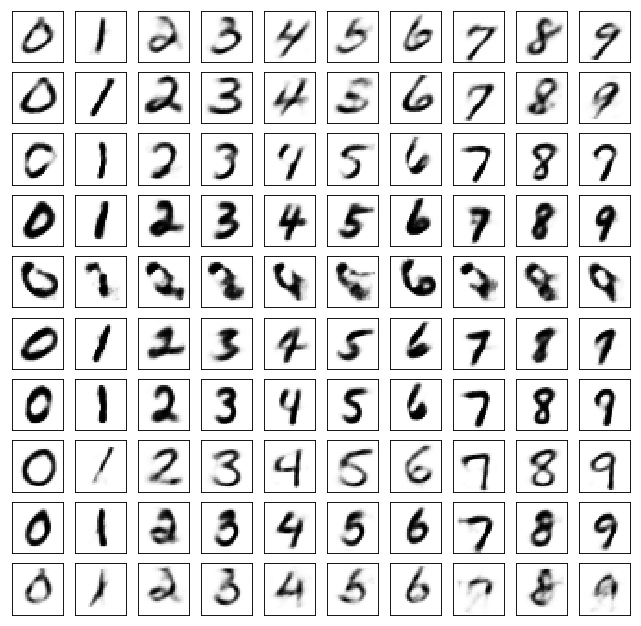

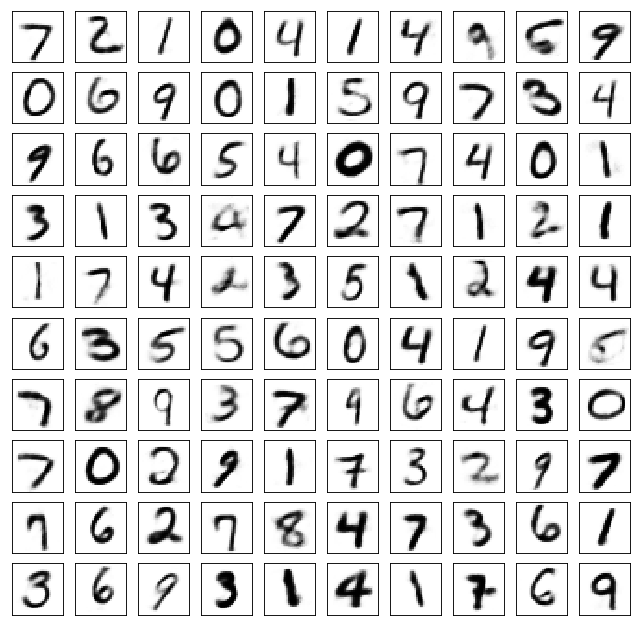

AAE with label in latent


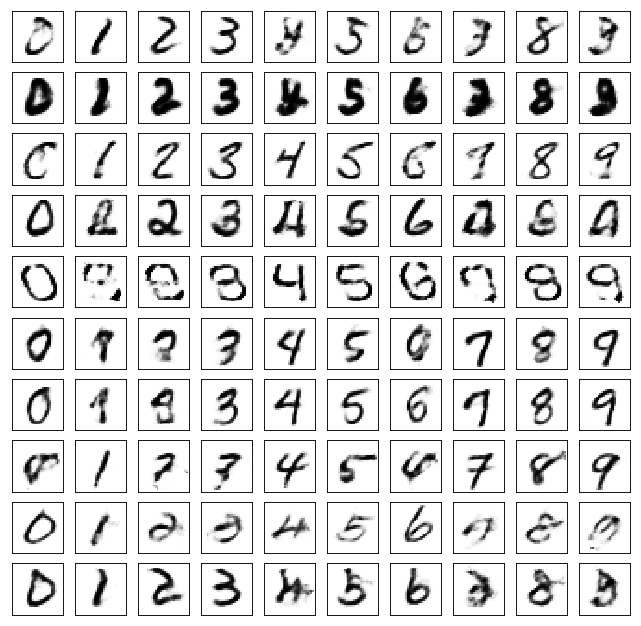

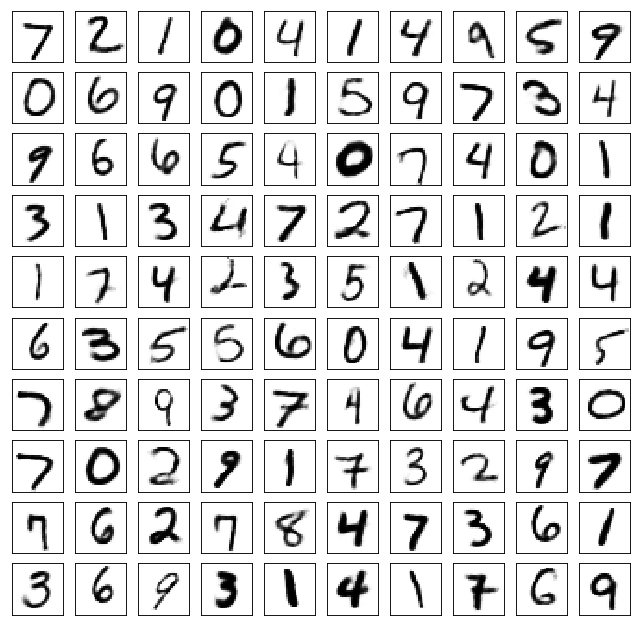

Train Epoch: 101 [0/50000 (0%)]	Losses E: 0.6834, AE: 0.0586, D: 0.6918
Train Epoch: 101 [25000/50000 (50%)]	Losses E: 0.7068, AE: 0.0618, D: 0.6939
Train Epoch: 101 [50000/50000 (100%)]	Losses E: 0.6812, AE: 0.0608, D: 0.6926
Test losses. E: 0.6831, AE: 0.0633, D: 0.6923
Train Epoch: 102 [0/50000 (0%)]	Losses E: 0.6828, AE: 0.0604, D: 0.6930
Train Epoch: 102 [25000/50000 (50%)]	Losses E: 0.6875, AE: 0.0629, D: 0.6932
Train Epoch: 102 [50000/50000 (100%)]	Losses E: 0.6898, AE: 0.0617, D: 0.6962
Test losses. E: 0.6897, AE: 0.0609, D: 0.6940
Train Epoch: 103 [0/50000 (0%)]	Losses E: 0.6879, AE: 0.0632, D: 0.6957
Train Epoch: 103 [25000/50000 (50%)]	Losses E: 0.6915, AE: 0.0583, D: 0.6929
Train Epoch: 103 [50000/50000 (100%)]	Losses E: 0.7026, AE: 0.0541, D: 0.6913
Test losses. E: 0.7020, AE: 0.0599, D: 0.6918
Train Epoch: 104 [0/50000 (0%)]	Losses E: 0.7027, AE: 0.0560, D: 0.6939
Train Epoch: 104 [25000/50000 (50%)]	Losses E: 0.6783, AE: 0.0610, D: 0.6976
Train Epoch: 104 [50000/50000 (1

Train Epoch: 131 [25000/50000 (50%)]	Losses E: 0.6914, AE: 0.0506, D: 0.6909
Train Epoch: 131 [50000/50000 (100%)]	Losses E: 0.6927, AE: 0.0461, D: 0.6921
Test losses. E: 0.6933, AE: 0.0554, D: 0.6914
Train Epoch: 132 [0/50000 (0%)]	Losses E: 0.6955, AE: 0.0473, D: 0.6906
Train Epoch: 132 [25000/50000 (50%)]	Losses E: 0.6902, AE: 0.0498, D: 0.6931
Train Epoch: 132 [50000/50000 (100%)]	Losses E: 0.6879, AE: 0.0510, D: 0.6941
Test losses. E: 0.6896, AE: 0.0550, D: 0.6935
Train Epoch: 133 [0/50000 (0%)]	Losses E: 0.6896, AE: 0.0541, D: 0.6955
Train Epoch: 133 [25000/50000 (50%)]	Losses E: 0.6951, AE: 0.0495, D: 0.6936
Train Epoch: 133 [50000/50000 (100%)]	Losses E: 0.6879, AE: 0.0511, D: 0.6922
Test losses. E: 0.6863, AE: 0.0538, D: 0.6930
Train Epoch: 134 [0/50000 (0%)]	Losses E: 0.6864, AE: 0.0486, D: 0.6934
Train Epoch: 134 [25000/50000 (50%)]	Losses E: 0.6873, AE: 0.0520, D: 0.6939
Train Epoch: 134 [50000/50000 (100%)]	Losses E: 0.6903, AE: 0.0479, D: 0.6934
Test losses. E: 0.6911, AE

Train Epoch: 161 [50000/50000 (100%)]	Losses E: 0.6927, AE: 0.0444, D: 0.6927
Test losses. E: 0.6920, AE: 0.0507, D: 0.6939
Train Epoch: 162 [0/50000 (0%)]	Losses E: 0.6933, AE: 0.0422, D: 0.6930
Train Epoch: 162 [25000/50000 (50%)]	Losses E: 0.7110, AE: 0.0439, D: 0.6904
Train Epoch: 162 [50000/50000 (100%)]	Losses E: 0.6858, AE: 0.0444, D: 0.6942
Test losses. E: 0.6864, AE: 0.0508, D: 0.6931
Train Epoch: 163 [0/50000 (0%)]	Losses E: 0.6878, AE: 0.0454, D: 0.6937
Train Epoch: 163 [25000/50000 (50%)]	Losses E: 0.7035, AE: 0.0450, D: 0.6915
Train Epoch: 163 [50000/50000 (100%)]	Losses E: 0.6920, AE: 0.0402, D: 0.6923
Test losses. E: 0.6889, AE: 0.0508, D: 0.6933
Train Epoch: 164 [0/50000 (0%)]	Losses E: 0.6908, AE: 0.0429, D: 0.6964
Train Epoch: 164 [25000/50000 (50%)]	Losses E: 0.6925, AE: 0.0430, D: 0.6938
Train Epoch: 164 [50000/50000 (100%)]	Losses E: 0.6918, AE: 0.0457, D: 0.6926
Test losses. E: 0.6891, AE: 0.0496, D: 0.6925
Train Epoch: 165 [0/50000 (0%)]	Losses E: 0.6888, AE: 0.0

Test losses. E: 0.6963, AE: 0.0486, D: 0.6919
Train Epoch: 192 [0/50000 (0%)]	Losses E: 0.6975, AE: 0.0374, D: 0.6917
Train Epoch: 192 [25000/50000 (50%)]	Losses E: 0.6897, AE: 0.0377, D: 0.6931
Train Epoch: 192 [50000/50000 (100%)]	Losses E: 0.7043, AE: 0.0401, D: 0.6929
Test losses. E: 0.7045, AE: 0.0486, D: 0.6925
Train Epoch: 193 [0/50000 (0%)]	Losses E: 0.7009, AE: 0.0429, D: 0.6937
Train Epoch: 193 [25000/50000 (50%)]	Losses E: 0.6998, AE: 0.0404, D: 0.6904
Train Epoch: 193 [50000/50000 (100%)]	Losses E: 0.6930, AE: 0.0412, D: 0.6937
Test losses. E: 0.6930, AE: 0.0489, D: 0.6935
Train Epoch: 194 [0/50000 (0%)]	Losses E: 0.6944, AE: 0.0431, D: 0.6924
Train Epoch: 194 [25000/50000 (50%)]	Losses E: 0.7042, AE: 0.0370, D: 0.6910
Train Epoch: 194 [50000/50000 (100%)]	Losses E: 0.7093, AE: 0.0403, D: 0.6953
Test losses. E: 0.7101, AE: 0.0494, D: 0.6925
Train Epoch: 195 [0/50000 (0%)]	Losses E: 0.7089, AE: 0.0394, D: 0.6957
Train Epoch: 195 [25000/50000 (50%)]	Losses E: 0.6953, AE: 0.04

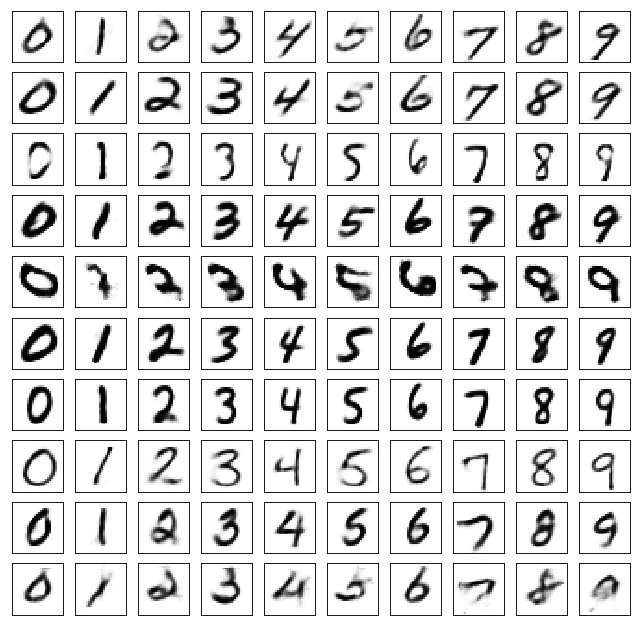

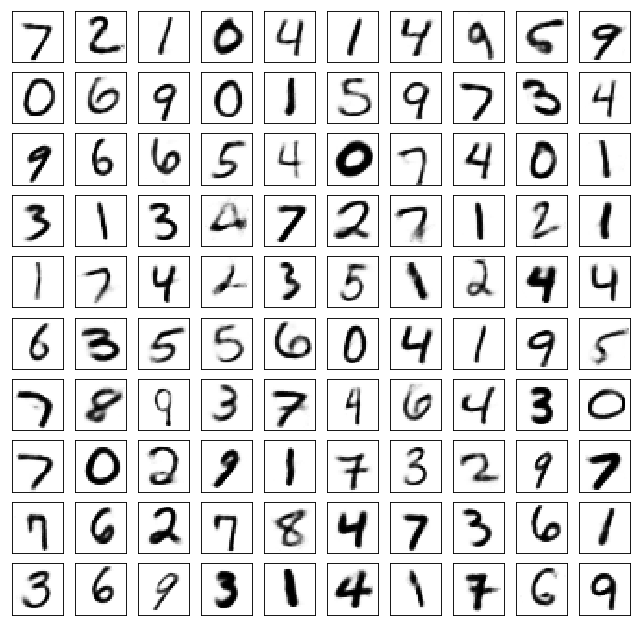

AAE with label in latent


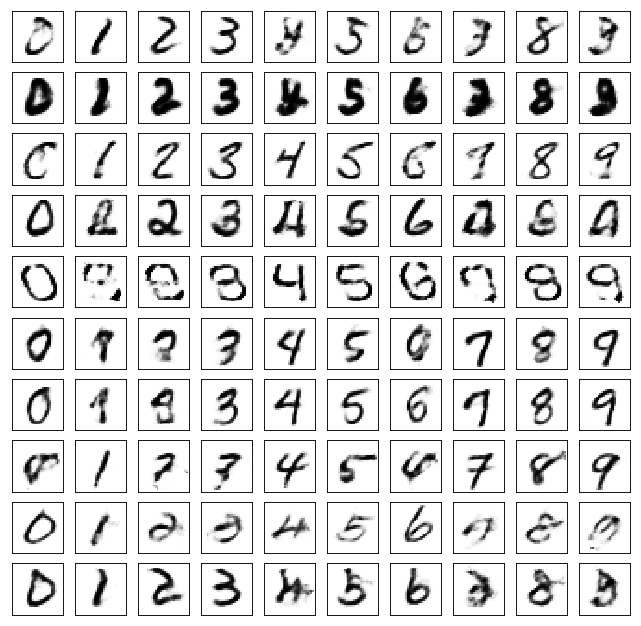

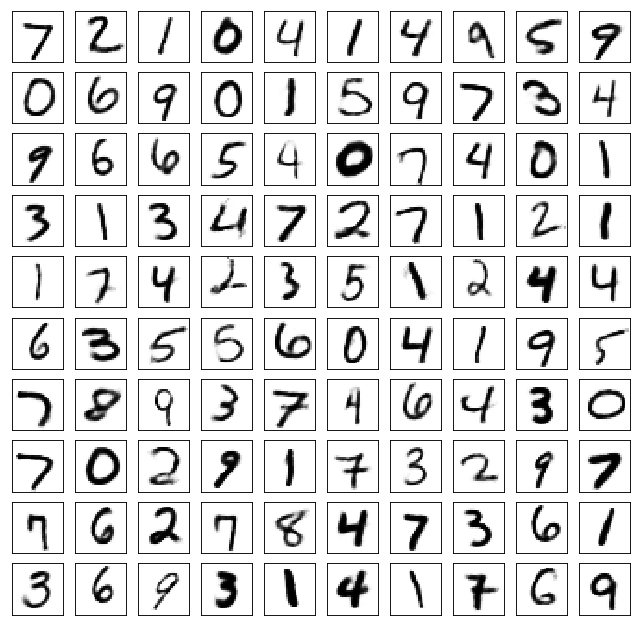

Train Epoch: 201 [0/50000 (0%)]	Losses E: 0.6956, AE: 0.0410, D: 0.6944
Train Epoch: 201 [25000/50000 (50%)]	Losses E: 0.6934, AE: 0.0418, D: 0.6918
Train Epoch: 201 [50000/50000 (100%)]	Losses E: 0.6959, AE: 0.0407, D: 0.6911
Test losses. E: 0.6949, AE: 0.0485, D: 0.6922
Train Epoch: 202 [0/50000 (0%)]	Losses E: 0.6941, AE: 0.0364, D: 0.6924
Train Epoch: 202 [25000/50000 (50%)]	Losses E: 0.7047, AE: 0.0390, D: 0.6916
Train Epoch: 202 [50000/50000 (100%)]	Losses E: 0.6931, AE: 0.0399, D: 0.6917
Test losses. E: 0.6945, AE: 0.0481, D: 0.6921
Train Epoch: 203 [0/50000 (0%)]	Losses E: 0.6955, AE: 0.0397, D: 0.6932
Train Epoch: 203 [25000/50000 (50%)]	Losses E: 0.6990, AE: 0.0390, D: 0.6914
Train Epoch: 203 [50000/50000 (100%)]	Losses E: 0.6909, AE: 0.0377, D: 0.6941
Test losses. E: 0.6922, AE: 0.0479, D: 0.6922
Train Epoch: 204 [0/50000 (0%)]	Losses E: 0.6907, AE: 0.0378, D: 0.6921
Train Epoch: 204 [25000/50000 (50%)]	Losses E: 0.7056, AE: 0.0384, D: 0.6928
Train Epoch: 204 [50000/50000 (1

Train Epoch: 231 [25000/50000 (50%)]	Losses E: 0.6972, AE: 0.0354, D: 0.6916
Train Epoch: 231 [50000/50000 (100%)]	Losses E: 0.6945, AE: 0.0358, D: 0.6924
Test losses. E: 0.6964, AE: 0.0474, D: 0.6921
Train Epoch: 232 [0/50000 (0%)]	Losses E: 0.6951, AE: 0.0351, D: 0.6927
Train Epoch: 232 [25000/50000 (50%)]	Losses E: 0.6885, AE: 0.0408, D: 0.6927
Train Epoch: 232 [50000/50000 (100%)]	Losses E: 0.6840, AE: 0.0373, D: 0.6951
Test losses. E: 0.6870, AE: 0.0474, D: 0.6922
Train Epoch: 233 [0/50000 (0%)]	Losses E: 0.6828, AE: 0.0363, D: 0.6927
Train Epoch: 233 [25000/50000 (50%)]	Losses E: 0.6904, AE: 0.0384, D: 0.6922
Train Epoch: 233 [50000/50000 (100%)]	Losses E: 0.6989, AE: 0.0368, D: 0.6916
Test losses. E: 0.6980, AE: 0.0478, D: 0.6920
Train Epoch: 234 [0/50000 (0%)]	Losses E: 0.7003, AE: 0.0354, D: 0.6923
Train Epoch: 234 [25000/50000 (50%)]	Losses E: 0.6877, AE: 0.0383, D: 0.6930
Train Epoch: 234 [50000/50000 (100%)]	Losses E: 0.6768, AE: 0.0367, D: 0.6916
Test losses. E: 0.6767, AE

Train Epoch: 261 [50000/50000 (100%)]	Losses E: 0.7082, AE: 0.0343, D: 0.6917
Test losses. E: 0.7052, AE: 0.0471, D: 0.6920
Train Epoch: 262 [0/50000 (0%)]	Losses E: 0.7073, AE: 0.0357, D: 0.6912
Train Epoch: 262 [25000/50000 (50%)]	Losses E: 0.7074, AE: 0.0343, D: 0.6906
Train Epoch: 262 [50000/50000 (100%)]	Losses E: 0.7046, AE: 0.0355, D: 0.6909
Test losses. E: 0.7028, AE: 0.0470, D: 0.6916
Train Epoch: 263 [0/50000 (0%)]	Losses E: 0.7073, AE: 0.0339, D: 0.6927
Train Epoch: 263 [25000/50000 (50%)]	Losses E: 0.7034, AE: 0.0344, D: 0.6927
Train Epoch: 263 [50000/50000 (100%)]	Losses E: 0.6924, AE: 0.0342, D: 0.6943
Test losses. E: 0.6913, AE: 0.0476, D: 0.6927
Train Epoch: 264 [0/50000 (0%)]	Losses E: 0.6893, AE: 0.0360, D: 0.6937
Train Epoch: 264 [25000/50000 (50%)]	Losses E: 0.6891, AE: 0.0360, D: 0.6926
Train Epoch: 264 [50000/50000 (100%)]	Losses E: 0.6910, AE: 0.0375, D: 0.6932
Test losses. E: 0.6900, AE: 0.0473, D: 0.6922
Train Epoch: 265 [0/50000 (0%)]	Losses E: 0.6890, AE: 0.0

Test losses. E: 0.6838, AE: 0.0475, D: 0.6929
Train Epoch: 292 [0/50000 (0%)]	Losses E: 0.6898, AE: 0.0337, D: 0.6910
Train Epoch: 292 [25000/50000 (50%)]	Losses E: 0.7009, AE: 0.0360, D: 0.6931
Train Epoch: 292 [50000/50000 (100%)]	Losses E: 0.6966, AE: 0.0314, D: 0.6921
Test losses. E: 0.6968, AE: 0.0467, D: 0.6918
Train Epoch: 293 [0/50000 (0%)]	Losses E: 0.6999, AE: 0.0312, D: 0.6922
Train Epoch: 293 [25000/50000 (50%)]	Losses E: 0.6991, AE: 0.0353, D: 0.6910
Train Epoch: 293 [50000/50000 (100%)]	Losses E: 0.7044, AE: 0.0334, D: 0.6925
Test losses. E: 0.7045, AE: 0.0468, D: 0.6924
Train Epoch: 294 [0/50000 (0%)]	Losses E: 0.7055, AE: 0.0333, D: 0.6928
Train Epoch: 294 [25000/50000 (50%)]	Losses E: 0.6952, AE: 0.0333, D: 0.6905
Train Epoch: 294 [50000/50000 (100%)]	Losses E: 0.6936, AE: 0.0351, D: 0.6954
Test losses. E: 0.6956, AE: 0.0475, D: 0.6930
Train Epoch: 295 [0/50000 (0%)]	Losses E: 0.6933, AE: 0.0330, D: 0.6952
Train Epoch: 295 [25000/50000 (50%)]	Losses E: 0.6858, AE: 0.03

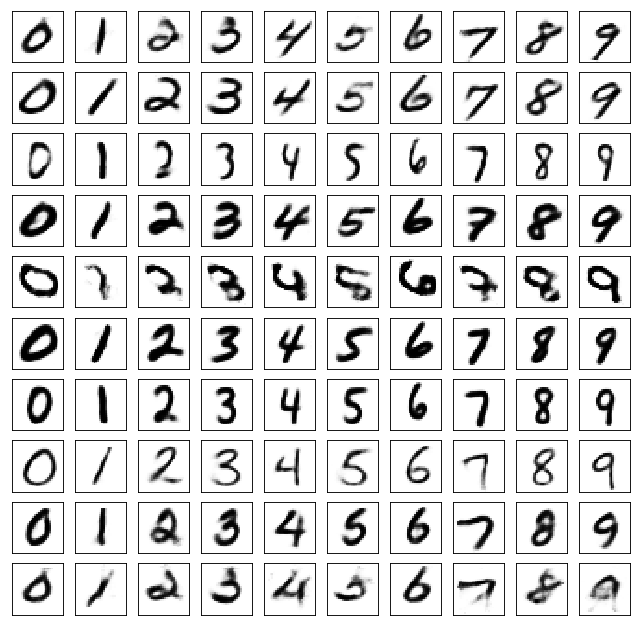

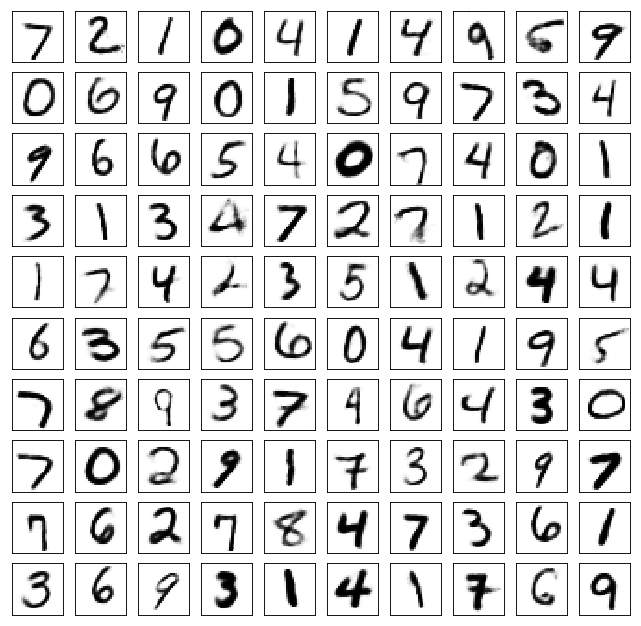

AAE with label in latent


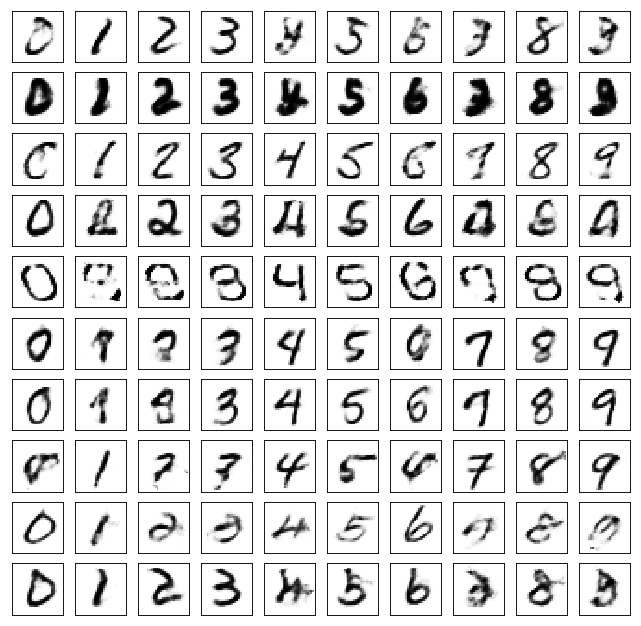

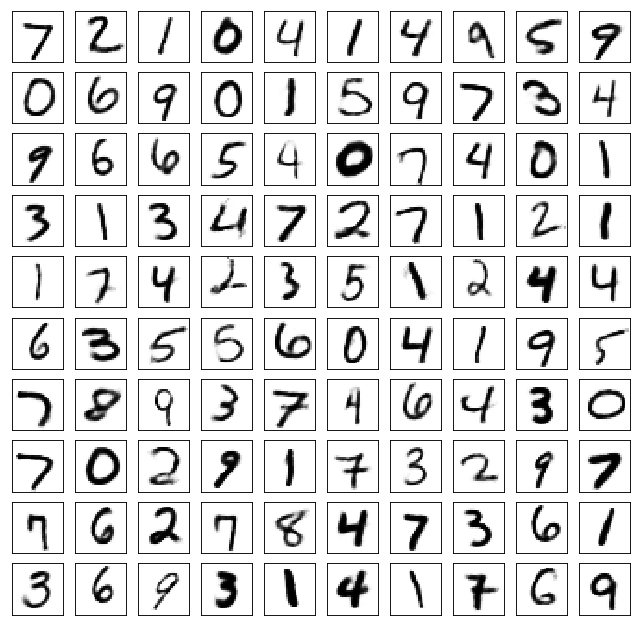

Train Epoch: 301 [0/50000 (0%)]	Losses E: 0.6933, AE: 0.0326, D: 0.6924
Train Epoch: 301 [25000/50000 (50%)]	Losses E: 0.6804, AE: 0.0344, D: 0.6924
Train Epoch: 301 [50000/50000 (100%)]	Losses E: 0.6880, AE: 0.0318, D: 0.6919
Test losses. E: 0.6883, AE: 0.0471, D: 0.6923
Train Epoch: 302 [0/50000 (0%)]	Losses E: 0.6865, AE: 0.0346, D: 0.6934
Train Epoch: 302 [25000/50000 (50%)]	Losses E: 0.6990, AE: 0.0362, D: 0.6920
Train Epoch: 302 [50000/50000 (100%)]	Losses E: 0.6906, AE: 0.0331, D: 0.6930
Test losses. E: 0.6878, AE: 0.0475, D: 0.6933
Train Epoch: 303 [0/50000 (0%)]	Losses E: 0.6888, AE: 0.0331, D: 0.6934
Train Epoch: 303 [25000/50000 (50%)]	Losses E: 0.6958, AE: 0.0363, D: 0.6956
Train Epoch: 303 [50000/50000 (100%)]	Losses E: 0.7029, AE: 0.0340, D: 0.6930
Test losses. E: 0.7037, AE: 0.0473, D: 0.6923
Train Epoch: 304 [0/50000 (0%)]	Losses E: 0.7051, AE: 0.0317, D: 0.6910
Train Epoch: 304 [25000/50000 (50%)]	Losses E: 0.7060, AE: 0.0337, D: 0.6939
Train Epoch: 304 [50000/50000 (1

Train Epoch: 331 [25000/50000 (50%)]	Losses E: 0.6900, AE: 0.0323, D: 0.6948
Train Epoch: 331 [50000/50000 (100%)]	Losses E: 0.6893, AE: 0.0323, D: 0.6938
Test losses. E: 0.6877, AE: 0.0475, D: 0.6926
Train Epoch: 332 [0/50000 (0%)]	Losses E: 0.6880, AE: 0.0309, D: 0.6943
Train Epoch: 332 [25000/50000 (50%)]	Losses E: 0.6963, AE: 0.0315, D: 0.6926
Train Epoch: 332 [50000/50000 (100%)]	Losses E: 0.6916, AE: 0.0318, D: 0.6930
Test losses. E: 0.6924, AE: 0.0470, D: 0.6925
Train Epoch: 333 [0/50000 (0%)]	Losses E: 0.6920, AE: 0.0326, D: 0.6912
Train Epoch: 333 [25000/50000 (50%)]	Losses E: 0.6980, AE: 0.0313, D: 0.6926
Train Epoch: 333 [50000/50000 (100%)]	Losses E: 0.6913, AE: 0.0318, D: 0.6940
Test losses. E: 0.6906, AE: 0.0468, D: 0.6922
Train Epoch: 334 [0/50000 (0%)]	Losses E: 0.6908, AE: 0.0288, D: 0.6919
Train Epoch: 334 [25000/50000 (50%)]	Losses E: 0.6937, AE: 0.0320, D: 0.6915
Train Epoch: 334 [50000/50000 (100%)]	Losses E: 0.6933, AE: 0.0323, D: 0.6916
Test losses. E: 0.6931, AE

Train Epoch: 361 [50000/50000 (100%)]	Losses E: 0.6896, AE: 0.0299, D: 0.6916
Test losses. E: 0.6882, AE: 0.0468, D: 0.6923
Train Epoch: 362 [0/50000 (0%)]	Losses E: 0.6928, AE: 0.0304, D: 0.6909
Train Epoch: 362 [25000/50000 (50%)]	Losses E: 0.6962, AE: 0.0317, D: 0.6924
Train Epoch: 362 [50000/50000 (100%)]	Losses E: 0.6918, AE: 0.0301, D: 0.6931
Test losses. E: 0.6911, AE: 0.0466, D: 0.6919
Train Epoch: 363 [0/50000 (0%)]	Losses E: 0.6907, AE: 0.0301, D: 0.6920
Train Epoch: 363 [25000/50000 (50%)]	Losses E: 0.6987, AE: 0.0301, D: 0.6908
Train Epoch: 363 [50000/50000 (100%)]	Losses E: 0.6905, AE: 0.0312, D: 0.6922
Test losses. E: 0.6911, AE: 0.0468, D: 0.6918
Train Epoch: 364 [0/50000 (0%)]	Losses E: 0.6913, AE: 0.0330, D: 0.6918
Train Epoch: 364 [25000/50000 (50%)]	Losses E: 0.6974, AE: 0.0308, D: 0.6941
Train Epoch: 364 [50000/50000 (100%)]	Losses E: 0.6885, AE: 0.0319, D: 0.6948
Test losses. E: 0.6893, AE: 0.0468, D: 0.6918
Train Epoch: 365 [0/50000 (0%)]	Losses E: 0.6894, AE: 0.0

Test losses. E: 0.6988, AE: 0.0480, D: 0.6929
Train Epoch: 392 [0/50000 (0%)]	Losses E: 0.6961, AE: 0.0320, D: 0.6939
Train Epoch: 392 [25000/50000 (50%)]	Losses E: 0.6961, AE: 0.0295, D: 0.6930
Train Epoch: 392 [50000/50000 (100%)]	Losses E: 0.6913, AE: 0.0300, D: 0.6927
Test losses. E: 0.6911, AE: 0.0474, D: 0.6924
Train Epoch: 393 [0/50000 (0%)]	Losses E: 0.6930, AE: 0.0291, D: 0.6905
Train Epoch: 393 [25000/50000 (50%)]	Losses E: 0.6942, AE: 0.0329, D: 0.6912
Train Epoch: 393 [50000/50000 (100%)]	Losses E: 0.6876, AE: 0.0299, D: 0.6953
Test losses. E: 0.6927, AE: 0.0470, D: 0.6925
Train Epoch: 394 [0/50000 (0%)]	Losses E: 0.6937, AE: 0.0305, D: 0.6936
Train Epoch: 394 [25000/50000 (50%)]	Losses E: 0.6916, AE: 0.0302, D: 0.6926
Train Epoch: 394 [50000/50000 (100%)]	Losses E: 0.7035, AE: 0.0299, D: 0.6920
Test losses. E: 0.7042, AE: 0.0471, D: 0.6920
Train Epoch: 395 [0/50000 (0%)]	Losses E: 0.7063, AE: 0.0298, D: 0.6933
Train Epoch: 395 [25000/50000 (50%)]	Losses E: 0.6861, AE: 0.02

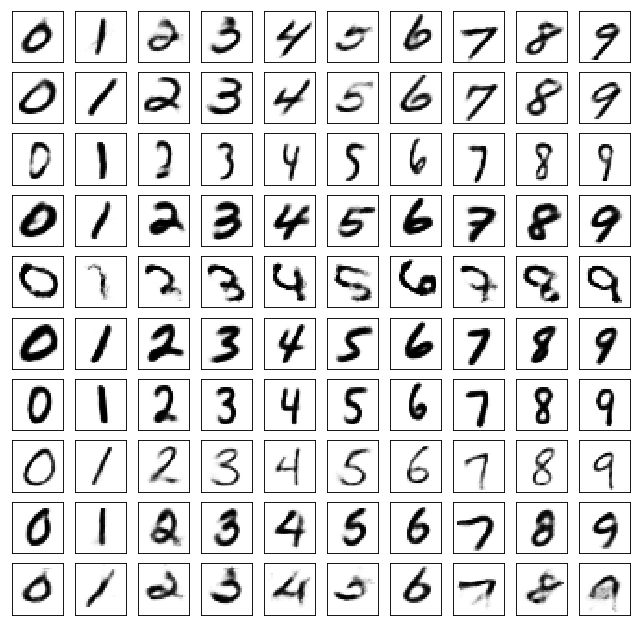

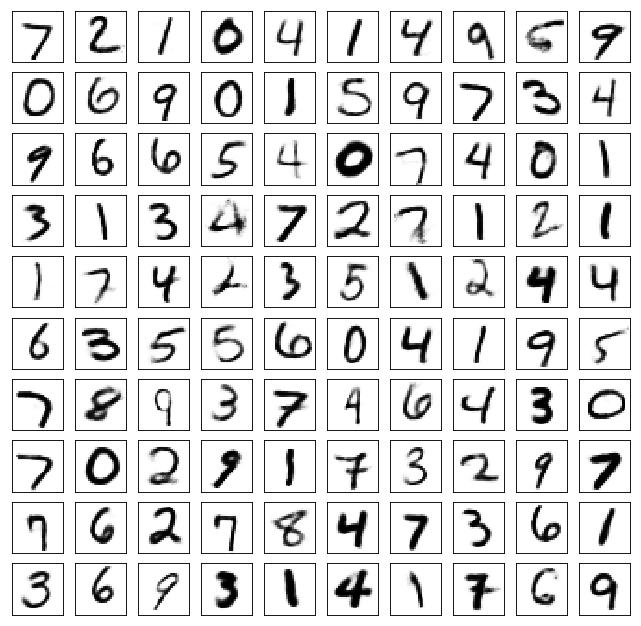

AAE with label in latent


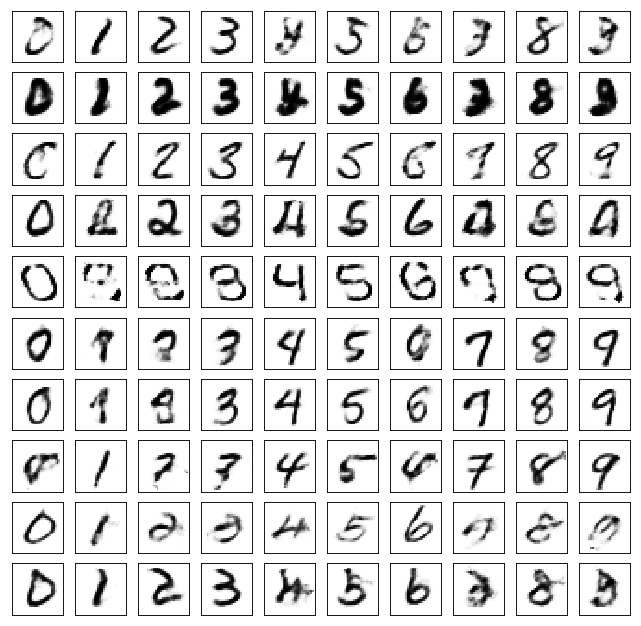

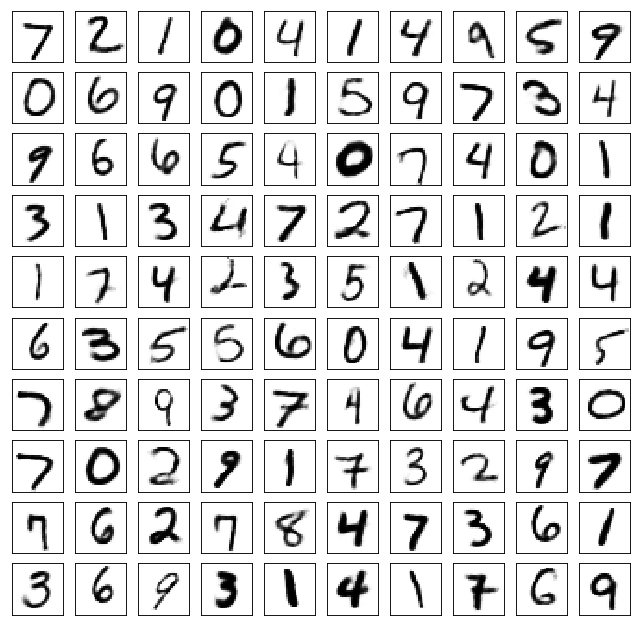

Train Epoch: 401 [0/50000 (0%)]	Losses E: 0.6875, AE: 0.0311, D: 0.6927
Train Epoch: 401 [25000/50000 (50%)]	Losses E: 0.6882, AE: 0.0296, D: 0.6944
Train Epoch: 401 [50000/50000 (100%)]	Losses E: 0.6950, AE: 0.0306, D: 0.6916
Test losses. E: 0.6948, AE: 0.0474, D: 0.6919
Train Epoch: 402 [0/50000 (0%)]	Losses E: 0.6985, AE: 0.0299, D: 0.6918
Train Epoch: 402 [25000/50000 (50%)]	Losses E: 0.6862, AE: 0.0284, D: 0.6914
Train Epoch: 402 [50000/50000 (100%)]	Losses E: 0.6896, AE: 0.0289, D: 0.6904
Test losses. E: 0.6884, AE: 0.0467, D: 0.6920
Train Epoch: 403 [0/50000 (0%)]	Losses E: 0.6886, AE: 0.0297, D: 0.6930
Train Epoch: 403 [25000/50000 (50%)]	Losses E: 0.6980, AE: 0.0287, D: 0.6905
Train Epoch: 403 [50000/50000 (100%)]	Losses E: 0.6944, AE: 0.0329, D: 0.6923
Test losses. E: 0.6919, AE: 0.0472, D: 0.6923
Train Epoch: 404 [0/50000 (0%)]	Losses E: 0.6912, AE: 0.0301, D: 0.6926
Train Epoch: 404 [25000/50000 (50%)]	Losses E: 0.6956, AE: 0.0316, D: 0.6956
Train Epoch: 404 [50000/50000 (1

Train Epoch: 431 [25000/50000 (50%)]	Losses E: 0.6943, AE: 0.0292, D: 0.6938
Train Epoch: 431 [50000/50000 (100%)]	Losses E: 0.6950, AE: 0.0287, D: 0.6921
Test losses. E: 0.6932, AE: 0.0479, D: 0.6923
Train Epoch: 432 [0/50000 (0%)]	Losses E: 0.6926, AE: 0.0309, D: 0.6931
Train Epoch: 432 [25000/50000 (50%)]	Losses E: 0.6950, AE: 0.0307, D: 0.6895
Train Epoch: 432 [50000/50000 (100%)]	Losses E: 0.7013, AE: 0.0287, D: 0.6942
Test losses. E: 0.7003, AE: 0.0475, D: 0.6926
Train Epoch: 433 [0/50000 (0%)]	Losses E: 0.6986, AE: 0.0287, D: 0.6939
Train Epoch: 433 [25000/50000 (50%)]	Losses E: 0.6917, AE: 0.0298, D: 0.6915
Train Epoch: 433 [50000/50000 (100%)]	Losses E: 0.6922, AE: 0.0294, D: 0.6912
Test losses. E: 0.6930, AE: 0.0478, D: 0.6929
Train Epoch: 434 [0/50000 (0%)]	Losses E: 0.6936, AE: 0.0306, D: 0.6941
Train Epoch: 434 [25000/50000 (50%)]	Losses E: 0.6858, AE: 0.0289, D: 0.6944
Train Epoch: 434 [50000/50000 (100%)]	Losses E: 0.6929, AE: 0.0288, D: 0.6916
Test losses. E: 0.6934, AE

Train Epoch: 461 [50000/50000 (100%)]	Losses E: 0.6934, AE: 0.0269, D: 0.6906
Test losses. E: 0.6920, AE: 0.0473, D: 0.6920
Train Epoch: 462 [0/50000 (0%)]	Losses E: 0.6890, AE: 0.0277, D: 0.6920
Train Epoch: 462 [25000/50000 (50%)]	Losses E: 0.6937, AE: 0.0290, D: 0.6909
Train Epoch: 462 [50000/50000 (100%)]	Losses E: 0.6898, AE: 0.0289, D: 0.6926
Test losses. E: 0.6897, AE: 0.0479, D: 0.6925
Train Epoch: 463 [0/50000 (0%)]	Losses E: 0.6869, AE: 0.0299, D: 0.6952
Train Epoch: 463 [25000/50000 (50%)]	Losses E: 0.6919, AE: 0.0286, D: 0.6939
Train Epoch: 463 [50000/50000 (100%)]	Losses E: 0.6965, AE: 0.0283, D: 0.6917
Test losses. E: 0.6946, AE: 0.0475, D: 0.6923
Train Epoch: 464 [0/50000 (0%)]	Losses E: 0.6982, AE: 0.0266, D: 0.6918
Train Epoch: 464 [25000/50000 (50%)]	Losses E: 0.6979, AE: 0.0273, D: 0.6921
Train Epoch: 464 [50000/50000 (100%)]	Losses E: 0.6976, AE: 0.0280, D: 0.6924
Test losses. E: 0.6960, AE: 0.0477, D: 0.6923
Train Epoch: 465 [0/50000 (0%)]	Losses E: 0.6963, AE: 0.0

Test losses. E: 0.6979, AE: 0.0477, D: 0.6921
Train Epoch: 492 [0/50000 (0%)]	Losses E: 0.6976, AE: 0.0267, D: 0.6907
Train Epoch: 492 [25000/50000 (50%)]	Losses E: 0.6983, AE: 0.0279, D: 0.6931
Train Epoch: 492 [50000/50000 (100%)]	Losses E: 0.6887, AE: 0.0266, D: 0.6929
Test losses. E: 0.6860, AE: 0.0477, D: 0.6920
Train Epoch: 493 [0/50000 (0%)]	Losses E: 0.6865, AE: 0.0294, D: 0.6933
Train Epoch: 493 [25000/50000 (50%)]	Losses E: 0.6930, AE: 0.0254, D: 0.6918
Train Epoch: 493 [50000/50000 (100%)]	Losses E: 0.6898, AE: 0.0280, D: 0.6920
Test losses. E: 0.6878, AE: 0.0477, D: 0.6925
Train Epoch: 494 [0/50000 (0%)]	Losses E: 0.6864, AE: 0.0292, D: 0.6944
Train Epoch: 494 [25000/50000 (50%)]	Losses E: 0.6919, AE: 0.0288, D: 0.6947
Train Epoch: 494 [50000/50000 (100%)]	Losses E: 0.6970, AE: 0.0273, D: 0.6948
Test losses. E: 0.6943, AE: 0.0485, D: 0.6928
Train Epoch: 495 [0/50000 (0%)]	Losses E: 0.6938, AE: 0.0291, D: 0.6897
Train Epoch: 495 [25000/50000 (50%)]	Losses E: 0.7003, AE: 0.02

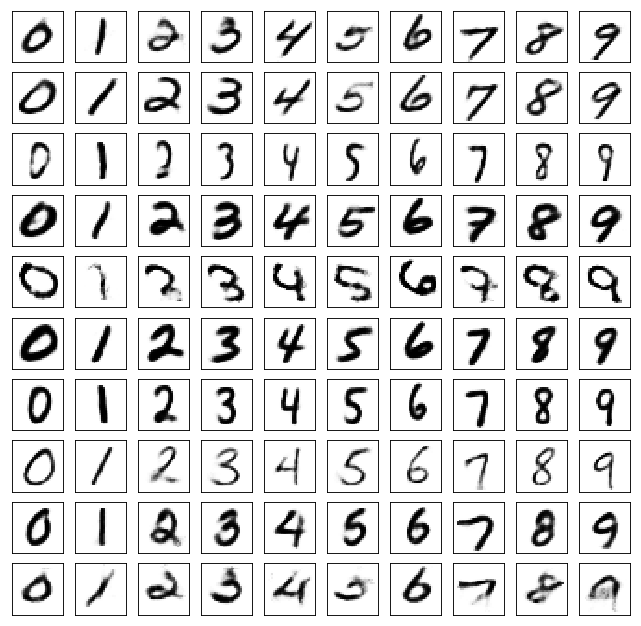

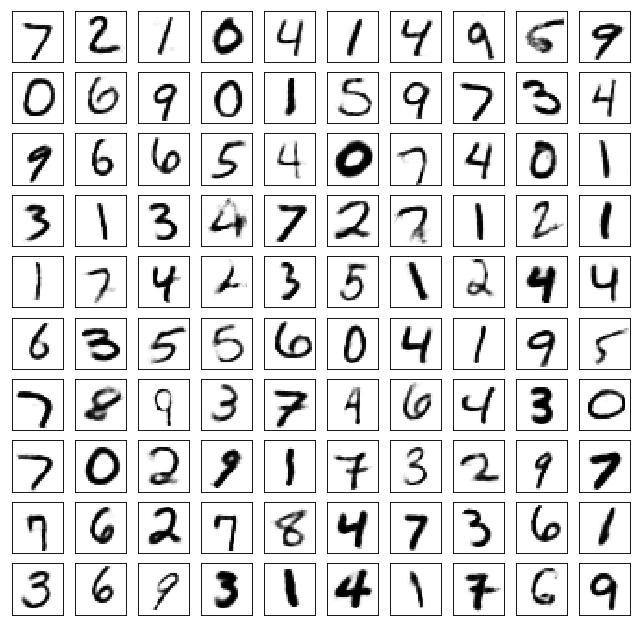

AAE with label in latent


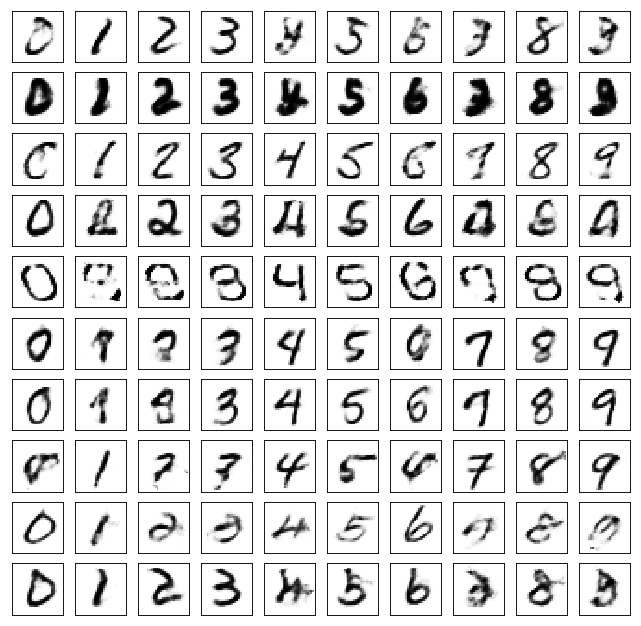

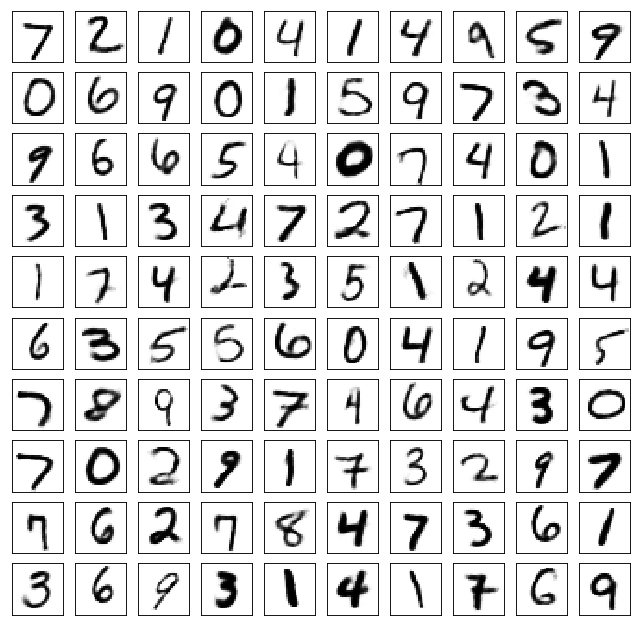

Train Epoch: 501 [0/50000 (0%)]	Losses E: 0.6963, AE: 0.0294, D: 0.6926
Train Epoch: 501 [25000/50000 (50%)]	Losses E: 0.6950, AE: 0.0291, D: 0.6907
Train Epoch: 501 [50000/50000 (100%)]	Losses E: 0.6892, AE: 0.0277, D: 0.6940
Test losses. E: 0.6894, AE: 0.0480, D: 0.6928
Train Epoch: 502 [0/50000 (0%)]	Losses E: 0.6911, AE: 0.0269, D: 0.6931
Train Epoch: 502 [25000/50000 (50%)]	Losses E: 0.7032, AE: 0.0269, D: 0.6924
Train Epoch: 502 [50000/50000 (100%)]	Losses E: 0.6957, AE: 0.0293, D: 0.6916
Test losses. E: 0.6959, AE: 0.0478, D: 0.6924
Train Epoch: 503 [0/50000 (0%)]	Losses E: 0.6967, AE: 0.0287, D: 0.6931
Train Epoch: 503 [25000/50000 (50%)]	Losses E: 0.6871, AE: 0.0273, D: 0.6946
Train Epoch: 503 [50000/50000 (100%)]	Losses E: 0.6936, AE: 0.0265, D: 0.6929
Test losses. E: 0.6939, AE: 0.0477, D: 0.6922
Train Epoch: 504 [0/50000 (0%)]	Losses E: 0.6944, AE: 0.0276, D: 0.6913
Train Epoch: 504 [25000/50000 (50%)]	Losses E: 0.6853, AE: 0.0293, D: 0.6933
Train Epoch: 504 [50000/50000 (1

Train Epoch: 531 [25000/50000 (50%)]	Losses E: 0.6925, AE: 0.0266, D: 0.6955
Train Epoch: 531 [50000/50000 (100%)]	Losses E: 0.6876, AE: 0.0264, D: 0.6931
Test losses. E: 0.6864, AE: 0.0482, D: 0.6919
Train Epoch: 532 [0/50000 (0%)]	Losses E: 0.6868, AE: 0.0271, D: 0.6921
Train Epoch: 532 [25000/50000 (50%)]	Losses E: 0.7013, AE: 0.0261, D: 0.6931
Train Epoch: 532 [50000/50000 (100%)]	Losses E: 0.7008, AE: 0.0284, D: 0.6941
Test losses. E: 0.7011, AE: 0.0484, D: 0.6923
Train Epoch: 533 [0/50000 (0%)]	Losses E: 0.7011, AE: 0.0274, D: 0.6943
Train Epoch: 533 [25000/50000 (50%)]	Losses E: 0.7005, AE: 0.0256, D: 0.6933
Train Epoch: 533 [50000/50000 (100%)]	Losses E: 0.6855, AE: 0.0287, D: 0.6941
Test losses. E: 0.6894, AE: 0.0483, D: 0.6922
Train Epoch: 534 [0/50000 (0%)]	Losses E: 0.6840, AE: 0.0284, D: 0.6932
Train Epoch: 534 [25000/50000 (50%)]	Losses E: 0.6883, AE: 0.0264, D: 0.6933
Train Epoch: 534 [50000/50000 (100%)]	Losses E: 0.6971, AE: 0.0260, D: 0.6926
Test losses. E: 0.6964, AE

Train Epoch: 561 [50000/50000 (100%)]	Losses E: 0.6932, AE: 0.0276, D: 0.6928
Test losses. E: 0.6950, AE: 0.0483, D: 0.6924
Train Epoch: 562 [0/50000 (0%)]	Losses E: 0.6939, AE: 0.0253, D: 0.6923
Train Epoch: 562 [25000/50000 (50%)]	Losses E: 0.6936, AE: 0.0243, D: 0.6909
Train Epoch: 562 [50000/50000 (100%)]	Losses E: 0.6905, AE: 0.0258, D: 0.6913
Test losses. E: 0.6884, AE: 0.0486, D: 0.6925
Train Epoch: 563 [0/50000 (0%)]	Losses E: 0.6877, AE: 0.0249, D: 0.6939
Train Epoch: 563 [25000/50000 (50%)]	Losses E: 0.6961, AE: 0.0288, D: 0.6949
Train Epoch: 563 [50000/50000 (100%)]	Losses E: 0.7003, AE: 0.0268, D: 0.6922
Test losses. E: 0.6952, AE: 0.0489, D: 0.6924
Train Epoch: 564 [0/50000 (0%)]	Losses E: 0.6960, AE: 0.0288, D: 0.6937
Train Epoch: 564 [25000/50000 (50%)]	Losses E: 0.7010, AE: 0.0283, D: 0.6944
Train Epoch: 564 [50000/50000 (100%)]	Losses E: 0.6871, AE: 0.0287, D: 0.6940
Test losses. E: 0.6925, AE: 0.0481, D: 0.6920
Train Epoch: 565 [0/50000 (0%)]	Losses E: 0.6930, AE: 0.0

KeyboardInterrupt: 

In [20]:
for epoch in range(1, 500):
  
     #true caae
    Enc_true.train()
    Dec_true.train()
    Disc_true.train()
    train_true(epoch, Enc_true , Dec_true, Disc_true, train_log)
    Enc_true.eval()
    Dec_true.eval()
    Disc_true.eval()
    test_true(Enc_true, Dec_true, Disc_true, valid_loader, epoch, test_log)
    if epoch % 100 == 0:
        print('True CAAE')
        fixed_gen_t = Dec_true(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_gen_t, (10, 10), True, fixed_folder + '%03d.png' % epoch)
        fixed_reconstruction_t = Dec_true(Enc_true(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_reconstruction_t, (10, 10), True, recon_folder + '%03d.png' % epoch)

        print('AAE with label in latent')
        fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
        fixed_reconstruction = Dec(Enc(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)
        

True CAAE


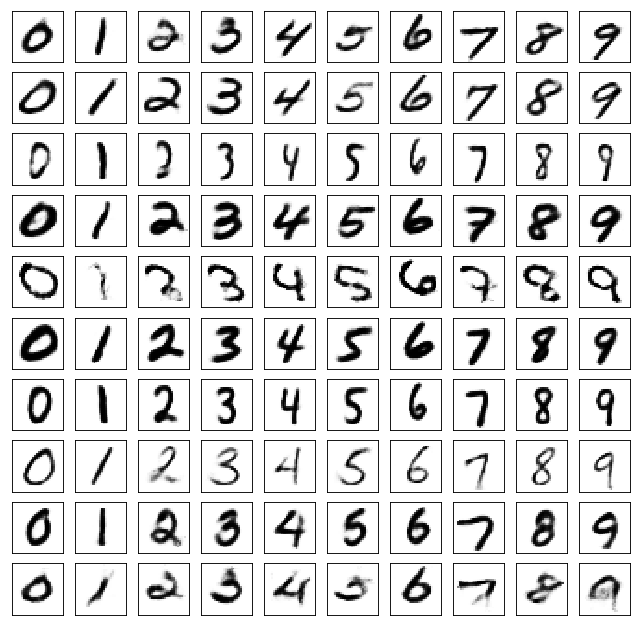

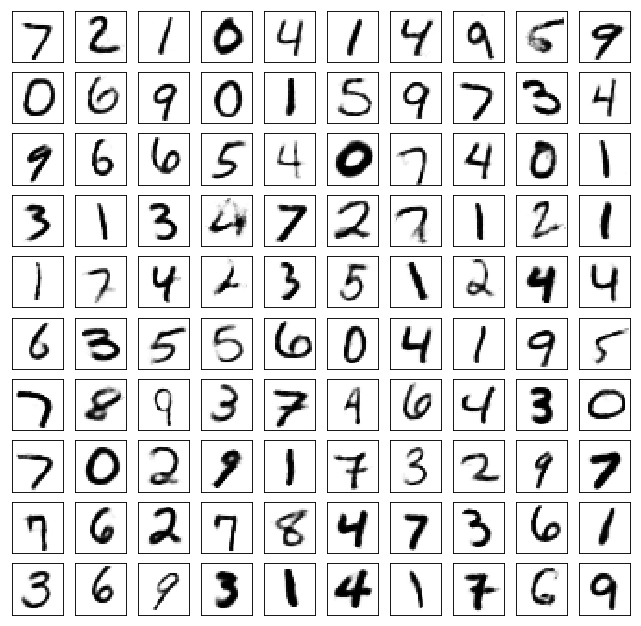

AAE with label in latent


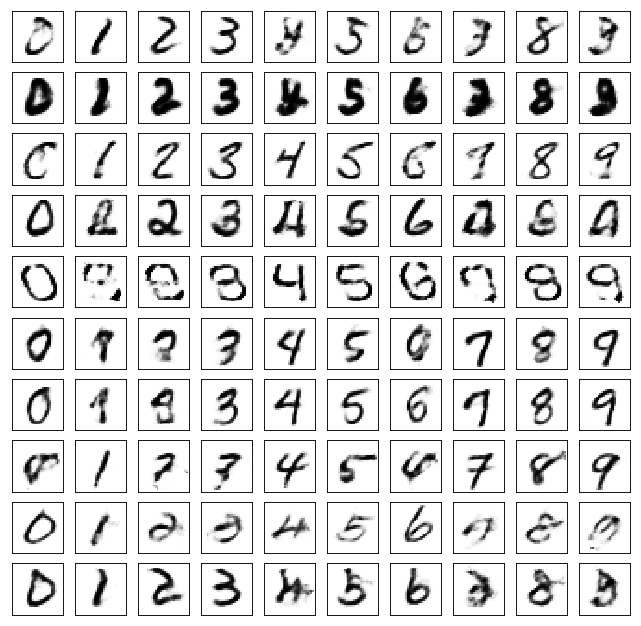

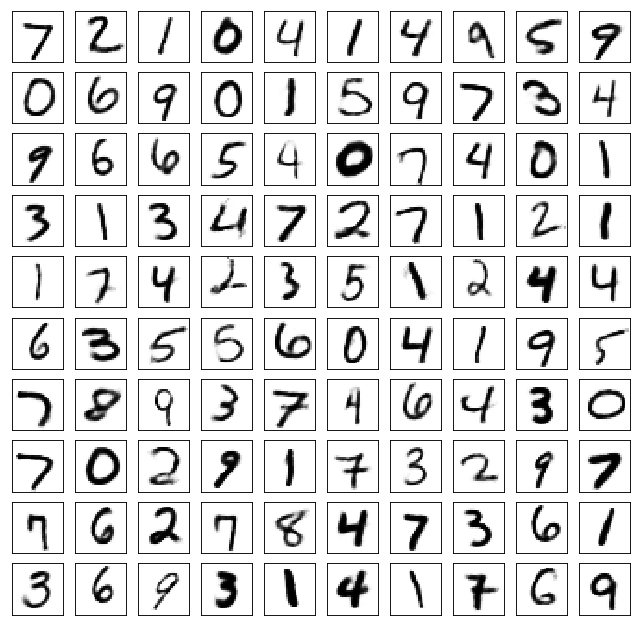

In [21]:
print('True CAAE')
fixed_gen_t = Dec_true(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
plot_mnist(fixed_gen_t, (10, 10), True, fixed_folder + '%03d.png' % epoch)
fixed_reconstruction_t = Dec_true(Enc_true(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
plot_mnist(fixed_reconstruction_t, (10, 10), True, recon_folder + '%03d.png' % epoch)

print('AAE with label in latent')
fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
fixed_reconstruction = Dec(Enc(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)

In [ ]:
##CLSFR

In [22]:
batch_size_clsf = 50
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size_clsf, valid=10000, transform=mnist_tanh)

In [23]:
class Net_clsf(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-2, l2=0.):
        super(Net_clsf, self).__init__()
        self.fc1 = nn.Linear(28*28, 28*28)
        self.fc2 = nn.Linear(28*28, 28*14)
        self.fc3 = nn.Linear(28*14 , 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(28*28)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        #self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        self.optim = optim.SGD(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [24]:
models = {'clsf': Net_clsf(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}


In [25]:
def train_clsf(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        #print(batch_idx)
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            #print(output.size())
            #print(target.size())
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [26]:
def test_clsf(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='mean').item() # sum up batch loss
                #test_loss[k] += m.loss(output, target).item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [27]:
for epoch in range(1, 50):
    for model in models.values():
        model.train()
    train_clsf(epoch, models)
    for model in models.values():
        model.eval()
    test_clsf(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses clsf: 2.283110
Train Epoch: 1 [10000/50000 (20%)]	Losses clsf: 0.636909
Train Epoch: 1 [20000/50000 (40%)]	Losses clsf: 0.685608
Train Epoch: 1 [30000/50000 (60%)]	Losses clsf: 0.373342
Train Epoch: 1 [40000/50000 (80%)]	Losses clsf: 0.512380
Train Epoch: 1 [50000/50000 (100%)]	Losses clsf: 0.252131
Test set:
clsf: Loss: 0.0068	Accuracy: 9014/10000 (90%)

Train Epoch: 2 [0/50000 (0%)]	Losses clsf: 0.483762
Train Epoch: 2 [10000/50000 (20%)]	Losses clsf: 0.536690
Train Epoch: 2 [20000/50000 (40%)]	Losses clsf: 0.354557
Train Epoch: 2 [30000/50000 (60%)]	Losses clsf: 0.208269
Train Epoch: 2 [40000/50000 (80%)]	Losses clsf: 0.760320
Train Epoch: 2 [50000/50000 (100%)]	Losses clsf: 0.162298
Test set:
clsf: Loss: 0.0057	Accuracy: 9177/10000 (91%)

Train Epoch: 3 [0/50000 (0%)]	Losses clsf: 0.172441
Train Epoch: 3 [10000/50000 (20%)]	Losses clsf: 0.182485
Train Epoch: 3 [20000/50000 (40%)]	Losses clsf: 0.690416
Train Epoch: 3 [30000/50000 (60%)]	Losses cl

Train Epoch: 21 [40000/50000 (80%)]	Losses clsf: 0.075863
Train Epoch: 21 [50000/50000 (100%)]	Losses clsf: 0.044933
Test set:
clsf: Loss: 0.0016	Accuracy: 9772/10000 (97%)

Train Epoch: 22 [0/50000 (0%)]	Losses clsf: 0.044474
Train Epoch: 22 [10000/50000 (20%)]	Losses clsf: 0.002673
Train Epoch: 22 [20000/50000 (40%)]	Losses clsf: 0.089146
Train Epoch: 22 [30000/50000 (60%)]	Losses clsf: 0.041993
Train Epoch: 22 [40000/50000 (80%)]	Losses clsf: 0.006080
Train Epoch: 22 [50000/50000 (100%)]	Losses clsf: 0.022360
Test set:
clsf: Loss: 0.0015	Accuracy: 9781/10000 (97%)

Train Epoch: 23 [0/50000 (0%)]	Losses clsf: 0.038995
Train Epoch: 23 [10000/50000 (20%)]	Losses clsf: 0.029612
Train Epoch: 23 [20000/50000 (40%)]	Losses clsf: 0.041074
Train Epoch: 23 [30000/50000 (60%)]	Losses clsf: 0.022384
Train Epoch: 23 [40000/50000 (80%)]	Losses clsf: 0.022224
Train Epoch: 23 [50000/50000 (100%)]	Losses clsf: 0.023080
Test set:
clsf: Loss: 0.0016	Accuracy: 9760/10000 (97%)

Train Epoch: 24 [0/50000

Train Epoch: 42 [10000/50000 (20%)]	Losses clsf: 0.068552
Train Epoch: 42 [20000/50000 (40%)]	Losses clsf: 0.007220
Train Epoch: 42 [30000/50000 (60%)]	Losses clsf: 0.033247
Train Epoch: 42 [40000/50000 (80%)]	Losses clsf: 0.002989
Train Epoch: 42 [50000/50000 (100%)]	Losses clsf: 0.039849
Test set:
clsf: Loss: 0.0016	Accuracy: 9797/10000 (97%)

Train Epoch: 43 [0/50000 (0%)]	Losses clsf: 0.010604
Train Epoch: 43 [10000/50000 (20%)]	Losses clsf: 0.025517
Train Epoch: 43 [20000/50000 (40%)]	Losses clsf: 0.008705
Train Epoch: 43 [30000/50000 (60%)]	Losses clsf: 0.005730
Train Epoch: 43 [40000/50000 (80%)]	Losses clsf: 0.003348
Train Epoch: 43 [50000/50000 (100%)]	Losses clsf: 0.022888
Test set:
clsf: Loss: 0.0016	Accuracy: 9804/10000 (98%)

Train Epoch: 44 [0/50000 (0%)]	Losses clsf: 0.007215
Train Epoch: 44 [10000/50000 (20%)]	Losses clsf: 0.026986
Train Epoch: 44 [20000/50000 (40%)]	Losses clsf: 0.040296
Train Epoch: 44 [30000/50000 (60%)]	Losses clsf: 0.007868
Train Epoch: 44 [40000/5

In [28]:
# FROM DATASET
#Train Epoch: 50 
#clsf: Loss: 0.0017	Accuracy: 9787/10000 (97%)

In [29]:
class Net_clsf_from_cnn(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-2, l2=0.):
        super(Net_clsf_from_cnn, self).__init__()
        self.fc1 = nn.Linear(prior_size, 28*28)
        self.fc2 = nn.Linear(28*28, 28*14)
        self.fc3 = nn.Linear(28*14 , 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(28*28)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        #self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        self.optim = optim.SGD(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        #x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [30]:
models = {'clsf_cnn': Net_clsf_from_cnn(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [31]:
def train_clsf_from_cnn(epoch, models, cnn_type):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        #print(batch_idx)
        for k, model in models.items():
            if cnn_type is 1:
                latent = Enc(data)
            else: latent = Enc_true(data) 
            model.optim.zero_grad()
            output = model(latent)
            #print(output.size())
            #print(target.size())
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [32]:
def test_clsf_from_cnn(models_from_cnn, loader, cnn_type, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                if cnn_type is 1:
                    latent = Enc(data)
                else: latent = Enc_true(data)
                output = m(latent)
                test_loss[k] += m.loss(output, target, reduction='mean').item() # sum up batch loss
                #test_loss[k] += m.loss(output, target).item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [36]:
for epoch in range(1, 100):
    for model in models.values():
        model.train()
    train_clsf_from_cnn(epoch, models, 1)
    for model in models.values():
        model.eval()
    test_clsf_from_cnn(models, valid_loader, 1 , test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses clsf_cnn: 2.326718
Train Epoch: 1 [10000/50000 (20%)]	Losses clsf_cnn: 1.590949
Train Epoch: 1 [20000/50000 (40%)]	Losses clsf_cnn: 1.351389
Train Epoch: 1 [30000/50000 (60%)]	Losses clsf_cnn: 1.398676
Train Epoch: 1 [40000/50000 (80%)]	Losses clsf_cnn: 1.143907
Train Epoch: 1 [50000/50000 (100%)]	Losses clsf_cnn: 1.147059
Test set:
clsf_cnn: Loss: 0.0245	Accuracy: 5789/10000 (57%)

Train Epoch: 2 [0/50000 (0%)]	Losses clsf_cnn: 1.239907
Train Epoch: 2 [10000/50000 (20%)]	Losses clsf_cnn: 1.290228
Train Epoch: 2 [20000/50000 (40%)]	Losses clsf_cnn: 1.137135
Train Epoch: 2 [30000/50000 (60%)]	Losses clsf_cnn: 1.165869
Train Epoch: 2 [40000/50000 (80%)]	Losses clsf_cnn: 1.295925
Train Epoch: 2 [50000/50000 (100%)]	Losses clsf_cnn: 1.148719
Test set:
clsf_cnn: Loss: 0.0217	Accuracy: 6291/10000 (62%)

Train Epoch: 3 [0/50000 (0%)]	Losses clsf_cnn: 0.765049
Train Epoch: 3 [10000/50000 (20%)]	Losses clsf_cnn: 1.098044
Train Epoch: 3 [20000/50000 (40%)]	Lo

Train Epoch: 20 [20000/50000 (40%)]	Losses clsf_cnn: 0.737817
Train Epoch: 20 [30000/50000 (60%)]	Losses clsf_cnn: 1.197649
Train Epoch: 20 [40000/50000 (80%)]	Losses clsf_cnn: 0.862033
Train Epoch: 20 [50000/50000 (100%)]	Losses clsf_cnn: 0.811746
Test set:
clsf_cnn: Loss: 0.0191	Accuracy: 6701/10000 (67%)

Train Epoch: 21 [0/50000 (0%)]	Losses clsf_cnn: 0.677113
Train Epoch: 21 [10000/50000 (20%)]	Losses clsf_cnn: 0.544409
Train Epoch: 21 [20000/50000 (40%)]	Losses clsf_cnn: 0.929092
Train Epoch: 21 [30000/50000 (60%)]	Losses clsf_cnn: 1.142896
Train Epoch: 21 [40000/50000 (80%)]	Losses clsf_cnn: 1.391915
Train Epoch: 21 [50000/50000 (100%)]	Losses clsf_cnn: 1.111686
Test set:
clsf_cnn: Loss: 0.0190	Accuracy: 6715/10000 (67%)

Train Epoch: 22 [0/50000 (0%)]	Losses clsf_cnn: 0.976799
Train Epoch: 22 [10000/50000 (20%)]	Losses clsf_cnn: 1.078391
Train Epoch: 22 [20000/50000 (40%)]	Losses clsf_cnn: 1.099043
Train Epoch: 22 [30000/50000 (60%)]	Losses clsf_cnn: 0.914041
Train Epoch: 22 [4

Train Epoch: 39 [30000/50000 (60%)]	Losses clsf_cnn: 0.775769
Train Epoch: 39 [40000/50000 (80%)]	Losses clsf_cnn: 1.132347
Train Epoch: 39 [50000/50000 (100%)]	Losses clsf_cnn: 0.958331
Test set:
clsf_cnn: Loss: 0.0187	Accuracy: 6752/10000 (67%)

Train Epoch: 40 [0/50000 (0%)]	Losses clsf_cnn: 1.224522
Train Epoch: 40 [10000/50000 (20%)]	Losses clsf_cnn: 0.936861
Train Epoch: 40 [20000/50000 (40%)]	Losses clsf_cnn: 0.944316
Train Epoch: 40 [30000/50000 (60%)]	Losses clsf_cnn: 0.909059
Train Epoch: 40 [40000/50000 (80%)]	Losses clsf_cnn: 0.805412
Train Epoch: 40 [50000/50000 (100%)]	Losses clsf_cnn: 0.789239
Test set:
clsf_cnn: Loss: 0.0188	Accuracy: 6777/10000 (67%)

Train Epoch: 41 [0/50000 (0%)]	Losses clsf_cnn: 0.775632
Train Epoch: 41 [10000/50000 (20%)]	Losses clsf_cnn: 1.025894
Train Epoch: 41 [20000/50000 (40%)]	Losses clsf_cnn: 0.876613
Train Epoch: 41 [30000/50000 (60%)]	Losses clsf_cnn: 0.836000
Train Epoch: 41 [40000/50000 (80%)]	Losses clsf_cnn: 1.004817
Train Epoch: 41 [5

Train Epoch: 58 [40000/50000 (80%)]	Losses clsf_cnn: 0.782984
Train Epoch: 58 [50000/50000 (100%)]	Losses clsf_cnn: 0.955352
Test set:
clsf_cnn: Loss: 0.0187	Accuracy: 6757/10000 (67%)

Train Epoch: 59 [0/50000 (0%)]	Losses clsf_cnn: 0.694031
Train Epoch: 59 [10000/50000 (20%)]	Losses clsf_cnn: 1.039251
Train Epoch: 59 [20000/50000 (40%)]	Losses clsf_cnn: 1.276747
Train Epoch: 59 [30000/50000 (60%)]	Losses clsf_cnn: 0.631632
Train Epoch: 59 [40000/50000 (80%)]	Losses clsf_cnn: 0.823593
Train Epoch: 59 [50000/50000 (100%)]	Losses clsf_cnn: 0.728372
Test set:
clsf_cnn: Loss: 0.0186	Accuracy: 6771/10000 (67%)

Train Epoch: 60 [0/50000 (0%)]	Losses clsf_cnn: 0.653072
Train Epoch: 60 [10000/50000 (20%)]	Losses clsf_cnn: 0.829523
Train Epoch: 60 [20000/50000 (40%)]	Losses clsf_cnn: 0.951404
Train Epoch: 60 [30000/50000 (60%)]	Losses clsf_cnn: 1.014456
Train Epoch: 60 [40000/50000 (80%)]	Losses clsf_cnn: 0.678919
Train Epoch: 60 [50000/50000 (100%)]	Losses clsf_cnn: 1.238104
Test set:
clsf_cn

Train Epoch: 77 [50000/50000 (100%)]	Losses clsf_cnn: 0.912531
Test set:
clsf_cnn: Loss: 0.0184	Accuracy: 6850/10000 (68%)

Train Epoch: 78 [0/50000 (0%)]	Losses clsf_cnn: 0.750441
Train Epoch: 78 [10000/50000 (20%)]	Losses clsf_cnn: 1.135597
Train Epoch: 78 [20000/50000 (40%)]	Losses clsf_cnn: 0.915362
Train Epoch: 78 [30000/50000 (60%)]	Losses clsf_cnn: 0.809604
Train Epoch: 78 [40000/50000 (80%)]	Losses clsf_cnn: 1.037462
Train Epoch: 78 [50000/50000 (100%)]	Losses clsf_cnn: 0.900765
Test set:
clsf_cnn: Loss: 0.0183	Accuracy: 6849/10000 (68%)

Train Epoch: 79 [0/50000 (0%)]	Losses clsf_cnn: 1.016022
Train Epoch: 79 [10000/50000 (20%)]	Losses clsf_cnn: 0.882126
Train Epoch: 79 [20000/50000 (40%)]	Losses clsf_cnn: 0.746314
Train Epoch: 79 [30000/50000 (60%)]	Losses clsf_cnn: 0.958745
Train Epoch: 79 [40000/50000 (80%)]	Losses clsf_cnn: 0.858999
Train Epoch: 79 [50000/50000 (100%)]	Losses clsf_cnn: 0.724412
Test set:
clsf_cnn: Loss: 0.0184	Accuracy: 6843/10000 (68%)

Train Epoch: 80 [0

Test set:
clsf_cnn: Loss: 0.0183	Accuracy: 6833/10000 (68%)

Train Epoch: 97 [0/50000 (0%)]	Losses clsf_cnn: 0.906820
Train Epoch: 97 [10000/50000 (20%)]	Losses clsf_cnn: 0.695768
Train Epoch: 97 [20000/50000 (40%)]	Losses clsf_cnn: 0.894133
Train Epoch: 97 [30000/50000 (60%)]	Losses clsf_cnn: 0.785758
Train Epoch: 97 [40000/50000 (80%)]	Losses clsf_cnn: 0.996512
Train Epoch: 97 [50000/50000 (100%)]	Losses clsf_cnn: 1.119985
Test set:
clsf_cnn: Loss: 0.0182	Accuracy: 6889/10000 (68%)

Train Epoch: 98 [0/50000 (0%)]	Losses clsf_cnn: 0.623511
Train Epoch: 98 [10000/50000 (20%)]	Losses clsf_cnn: 0.767782
Train Epoch: 98 [20000/50000 (40%)]	Losses clsf_cnn: 0.807800
Train Epoch: 98 [30000/50000 (60%)]	Losses clsf_cnn: 0.587001
Train Epoch: 98 [40000/50000 (80%)]	Losses clsf_cnn: 0.849514
Train Epoch: 98 [50000/50000 (100%)]	Losses clsf_cnn: 0.809654
Test set:
clsf_cnn: Loss: 0.0182	Accuracy: 6850/10000 (68%)

Train Epoch: 99 [0/50000 (0%)]	Losses clsf_cnn: 0.642888
Train Epoch: 99 [10000/5

In [ ]:
# FROM AAEC_C (with label inform)
# Train Epoch: 100
#clsf_cnn: Loss: 0.0183	Accuracy: 6848/10000 (68%)

In [37]:
for epoch in range(1, 100):
    for model in models.values():
        model.train()
    train_clsf_from_cnn(epoch, models, 2)
    for model in models.values():
        model.eval()
    test_clsf_from_cnn(models, valid_loader, 2 , test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses clsf_cnn: 5.013693
Train Epoch: 1 [10000/50000 (20%)]	Losses clsf_cnn: 2.617928
Train Epoch: 1 [20000/50000 (40%)]	Losses clsf_cnn: 2.812693
Train Epoch: 1 [30000/50000 (60%)]	Losses clsf_cnn: 2.451304
Train Epoch: 1 [40000/50000 (80%)]	Losses clsf_cnn: 2.352347
Train Epoch: 1 [50000/50000 (100%)]	Losses clsf_cnn: 2.357862
Test set:
clsf_cnn: Loss: 0.0471	Accuracy: 1288/10000 (12%)

Train Epoch: 2 [0/50000 (0%)]	Losses clsf_cnn: 2.236100
Train Epoch: 2 [10000/50000 (20%)]	Losses clsf_cnn: 2.223752
Train Epoch: 2 [20000/50000 (40%)]	Losses clsf_cnn: 2.361564
Train Epoch: 2 [30000/50000 (60%)]	Losses clsf_cnn: 2.300192
Train Epoch: 2 [40000/50000 (80%)]	Losses clsf_cnn: 2.339586
Train Epoch: 2 [50000/50000 (100%)]	Losses clsf_cnn: 2.225389
Test set:
clsf_cnn: Loss: 0.0459	Accuracy: 1405/10000 (14%)

Train Epoch: 3 [0/50000 (0%)]	Losses clsf_cnn: 2.333068
Train Epoch: 3 [10000/50000 (20%)]	Losses clsf_cnn: 2.332879
Train Epoch: 3 [20000/50000 (40%)]	Lo

Train Epoch: 20 [20000/50000 (40%)]	Losses clsf_cnn: 2.186324
Train Epoch: 20 [30000/50000 (60%)]	Losses clsf_cnn: 2.209402
Train Epoch: 20 [40000/50000 (80%)]	Losses clsf_cnn: 2.254952
Train Epoch: 20 [50000/50000 (100%)]	Losses clsf_cnn: 2.207509
Test set:
clsf_cnn: Loss: 0.0451	Accuracy: 1569/10000 (15%)

Train Epoch: 21 [0/50000 (0%)]	Losses clsf_cnn: 2.281841
Train Epoch: 21 [10000/50000 (20%)]	Losses clsf_cnn: 2.205525
Train Epoch: 21 [20000/50000 (40%)]	Losses clsf_cnn: 2.172983
Train Epoch: 21 [30000/50000 (60%)]	Losses clsf_cnn: 2.204283
Train Epoch: 21 [40000/50000 (80%)]	Losses clsf_cnn: 2.243085
Train Epoch: 21 [50000/50000 (100%)]	Losses clsf_cnn: 2.129903
Test set:
clsf_cnn: Loss: 0.0451	Accuracy: 1518/10000 (15%)

Train Epoch: 22 [0/50000 (0%)]	Losses clsf_cnn: 2.173301
Train Epoch: 22 [10000/50000 (20%)]	Losses clsf_cnn: 2.209477
Train Epoch: 22 [20000/50000 (40%)]	Losses clsf_cnn: 2.236841
Train Epoch: 22 [30000/50000 (60%)]	Losses clsf_cnn: 2.280138
Train Epoch: 22 [4

Train Epoch: 39 [30000/50000 (60%)]	Losses clsf_cnn: 2.123613
Train Epoch: 39 [40000/50000 (80%)]	Losses clsf_cnn: 2.241806
Train Epoch: 39 [50000/50000 (100%)]	Losses clsf_cnn: 2.258250
Test set:
clsf_cnn: Loss: 0.0450	Accuracy: 1557/10000 (15%)

Train Epoch: 40 [0/50000 (0%)]	Losses clsf_cnn: 2.058685
Train Epoch: 40 [10000/50000 (20%)]	Losses clsf_cnn: 2.272658
Train Epoch: 40 [20000/50000 (40%)]	Losses clsf_cnn: 2.215942
Train Epoch: 40 [30000/50000 (60%)]	Losses clsf_cnn: 2.237466
Train Epoch: 40 [40000/50000 (80%)]	Losses clsf_cnn: 2.109210
Train Epoch: 40 [50000/50000 (100%)]	Losses clsf_cnn: 2.176873
Test set:
clsf_cnn: Loss: 0.0450	Accuracy: 1565/10000 (15%)

Train Epoch: 41 [0/50000 (0%)]	Losses clsf_cnn: 2.348032
Train Epoch: 41 [10000/50000 (20%)]	Losses clsf_cnn: 2.193347
Train Epoch: 41 [20000/50000 (40%)]	Losses clsf_cnn: 2.266462
Train Epoch: 41 [30000/50000 (60%)]	Losses clsf_cnn: 2.233280
Train Epoch: 41 [40000/50000 (80%)]	Losses clsf_cnn: 2.194324
Train Epoch: 41 [5

Train Epoch: 58 [40000/50000 (80%)]	Losses clsf_cnn: 2.146565
Train Epoch: 58 [50000/50000 (100%)]	Losses clsf_cnn: 2.233196
Test set:
clsf_cnn: Loss: 0.0449	Accuracy: 1600/10000 (16%)

Train Epoch: 59 [0/50000 (0%)]	Losses clsf_cnn: 2.193899
Train Epoch: 59 [10000/50000 (20%)]	Losses clsf_cnn: 2.202650
Train Epoch: 59 [20000/50000 (40%)]	Losses clsf_cnn: 2.323500
Train Epoch: 59 [30000/50000 (60%)]	Losses clsf_cnn: 2.329332
Train Epoch: 59 [40000/50000 (80%)]	Losses clsf_cnn: 2.134293
Train Epoch: 59 [50000/50000 (100%)]	Losses clsf_cnn: 2.245086
Test set:
clsf_cnn: Loss: 0.0449	Accuracy: 1555/10000 (15%)

Train Epoch: 60 [0/50000 (0%)]	Losses clsf_cnn: 2.195392
Train Epoch: 60 [10000/50000 (20%)]	Losses clsf_cnn: 2.211970
Train Epoch: 60 [20000/50000 (40%)]	Losses clsf_cnn: 2.214999
Train Epoch: 60 [30000/50000 (60%)]	Losses clsf_cnn: 2.253848
Train Epoch: 60 [40000/50000 (80%)]	Losses clsf_cnn: 2.198948
Train Epoch: 60 [50000/50000 (100%)]	Losses clsf_cnn: 2.163181
Test set:
clsf_cn

Train Epoch: 77 [50000/50000 (100%)]	Losses clsf_cnn: 2.184895
Test set:
clsf_cnn: Loss: 0.0448	Accuracy: 1662/10000 (16%)

Train Epoch: 78 [0/50000 (0%)]	Losses clsf_cnn: 2.093990
Train Epoch: 78 [10000/50000 (20%)]	Losses clsf_cnn: 2.125716
Train Epoch: 78 [20000/50000 (40%)]	Losses clsf_cnn: 2.241922
Train Epoch: 78 [30000/50000 (60%)]	Losses clsf_cnn: 2.260283
Train Epoch: 78 [40000/50000 (80%)]	Losses clsf_cnn: 2.262283
Train Epoch: 78 [50000/50000 (100%)]	Losses clsf_cnn: 2.154465
Test set:
clsf_cnn: Loss: 0.0449	Accuracy: 1635/10000 (16%)

Train Epoch: 79 [0/50000 (0%)]	Losses clsf_cnn: 2.195781
Train Epoch: 79 [10000/50000 (20%)]	Losses clsf_cnn: 2.118000
Train Epoch: 79 [20000/50000 (40%)]	Losses clsf_cnn: 2.217195
Train Epoch: 79 [30000/50000 (60%)]	Losses clsf_cnn: 2.128957
Train Epoch: 79 [40000/50000 (80%)]	Losses clsf_cnn: 2.158874
Train Epoch: 79 [50000/50000 (100%)]	Losses clsf_cnn: 2.272777
Test set:
clsf_cnn: Loss: 0.0448	Accuracy: 1650/10000 (16%)

Train Epoch: 80 [0

Test set:
clsf_cnn: Loss: 0.0448	Accuracy: 1643/10000 (16%)

Train Epoch: 97 [0/50000 (0%)]	Losses clsf_cnn: 2.145062
Train Epoch: 97 [10000/50000 (20%)]	Losses clsf_cnn: 2.182464
Train Epoch: 97 [20000/50000 (40%)]	Losses clsf_cnn: 2.252567
Train Epoch: 97 [30000/50000 (60%)]	Losses clsf_cnn: 2.094161
Train Epoch: 97 [40000/50000 (80%)]	Losses clsf_cnn: 2.295891
Train Epoch: 97 [50000/50000 (100%)]	Losses clsf_cnn: 2.087420
Test set:
clsf_cnn: Loss: 0.0447	Accuracy: 1683/10000 (16%)

Train Epoch: 98 [0/50000 (0%)]	Losses clsf_cnn: 2.200916
Train Epoch: 98 [10000/50000 (20%)]	Losses clsf_cnn: 2.189783
Train Epoch: 98 [20000/50000 (40%)]	Losses clsf_cnn: 2.274665
Train Epoch: 98 [30000/50000 (60%)]	Losses clsf_cnn: 2.171744
Train Epoch: 98 [40000/50000 (80%)]	Losses clsf_cnn: 2.086676
Train Epoch: 98 [50000/50000 (100%)]	Losses clsf_cnn: 2.085957
Test set:
clsf_cnn: Loss: 0.0447	Accuracy: 1682/10000 (16%)

Train Epoch: 99 [0/50000 (0%)]	Losses clsf_cnn: 2.138735
Train Epoch: 99 [10000/5

In [ ]:
# FROM CAAE -  классифицируется существенно хуже, распутывание произошло
# Train Epoch: 100
#clsf_cnn: Loss: 0.0447	Accuracy: 1672/10000 (16%)